# Projet_P8 : Marine Institute Monthly Model Means (https://data.world/)

**SUMMARY**

Monthly mean values for oceanographic parameters in Irish waters from the Marine Institute SWAN and ROMS models. 

Mean values include:
 - Sea surface temperature (degreeCelsius) 
 - Sea bottom temperature (degreeCelsius) 
 - Surface salinity (PSU) 
 - Bottom salinity (PSU) 
 - Surface velocity (m/sec) 
 - Mixed layer depth 
 - Significant wave height (m)
 - Mean wave direction (degreeTrue) 
 - Mean wave period (sec) 
 
For the dynamic download service users can choose date time, parameter(s) and output file type. 
Note model means are only available for 12:00am for the 15th day of every month.

## Import librairies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
from scipy.stats import pearsonr
%matplotlib inline
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from math import pi

## Téléchargement des données

In [2]:
url   = 'INPUTS_FORMATION/P8_data_2021.csv' 
table = pd.read_csv(url, sep=',',encoding='utf-8')
table.drop(index=table.index[0], axis=0, inplace=True)

url2   = 'INPUTS_FORMATION/P8_data_2020.csv' 
table2 = pd.read_csv(url2, sep=',',encoding='utf-8')
table2.drop(index=table2.index[0], axis=0, inplace=True)

url3   = 'INPUTS_FORMATION/P8_data_2019.csv' 
table3 = pd.read_csv(url3, sep=',',encoding='utf-8')
table3.drop(index=table3.index[0], axis=0, inplace=True)

url4   = 'INPUTS_FORMATION/P8_data_2018.csv' 
table4 = pd.read_csv(url4, sep=',',encoding='utf-8')
table4.drop(index=table4.index[0], axis=0, inplace=True)

url5   = 'INPUTS_FORMATION/P8_data_2017.csv' 
table5 = pd.read_csv(url5, sep=',',encoding='utf-8')
table5.drop(index=table5.index[0], axis=0, inplace=True)

url6   = 'INPUTS_FORMATION/P8_data_2016.csv' 
table6 = pd.read_csv(url6, sep=',',encoding='utf-8')
table6.drop(index=table6.index[0], axis=0, inplace=True)

# concaténations des fichiers/tables
# table_2021 = table_2021.append(table_2020)
# table_2021 = table_2021.append(table_2019)
# table_2021 = table_2021.append(table_2018)
# table_2021 = table_2021.append(table_2017)

#list dataframe you want to append
frame = [table, table2, table3, table4, table5, table6]
myDataFrame = pd.DataFrame()
for df in frame:
    myDataFrame = myDataFrame.append(df)

# table_concat_orig = table_2020.copy()
# pd.concat([table_2018, table_2017], join="inner")

In [3]:
# test avec dataset LIGHT (1 value / 3)
# url   = 'INPUTS_FORMATION/IMI_Model_Stats_d846_7ece_f7a4.csv' #P8_data_2020
# table_2021 = pd.read_csv(url, sep=',',encoding='utf-8')# , header=[0,1])
# table_2021.head()

## Split données

In [4]:
table = myDataFrame.copy()

# Split colonne time
table[['date','heure']] = table['time'].str.split('T', n=1, expand=True)
first_column = table.pop('date')
table.insert(0, 'date', first_column)
table.drop(columns=['time','heure'], inplace=True)

In [5]:
# correction et conversion
table['date'] = table['date'].replace('U' ,'1970-01-01' )
table['date']  = pd.to_datetime(table['date'])

# création colonnées supplémentaires
table['year']  = table['date'].dt.year
table['month'] = table['date'].dt.month
sec_column = table.pop('year')
table.insert(1, 'year', sec_column)
thr_column = table.pop('month')
table.insert(2, 'month', thr_column)

## Data cleaning

In [6]:
print('\x1b[6;31;40m','nb of NAN values :',table.isnull().value_counts().unique()[1], 'soit', 100*round(table.isnull().value_counts().unique()[1]/table.shape[0],2),"%", '\x1b[0m')
table = table.dropna()

 nb of NAN values : 4114408 soit 21.0 % 


## Typage données

In [7]:
table.dtypes

date                       datetime64[ns]
year                                int64
month                               int64
latitude                           object
longitude                          object
sea_surface_temperature            object
sea_bottom_temperature             object
sea_surface_salinity               object
sea_bottom_salinity                object
sea_surface_x_velocity             object
sea_surface_y_velocity             object
mixed_layer_depth                  object
significant_wave_height            object
mean_wave_direction                object
mean_wave_period                   object
dtype: object

In [8]:
# conversion numérique
table = table[1:]
table[['latitude', 'longitude', 'sea_surface_temperature','sea_bottom_temperature', 'sea_surface_salinity', 
'sea_bottom_salinity','sea_surface_x_velocity', 'sea_surface_y_velocity', 'mixed_layer_depth','significant_wave_height', 
'mean_wave_direction', 'mean_wave_period']] = table[['latitude', 'longitude', 'sea_surface_temperature',
'sea_bottom_temperature', 'sea_surface_salinity', 'sea_bottom_salinity','sea_surface_x_velocity', 'sea_surface_y_velocity', 
'mixed_layer_depth','significant_wave_height', 'mean_wave_direction', 'mean_wave_period']].apply(pd.to_numeric)

# table[['year', 'month']] = table[['year', 'month']].apply(pd.to_datetime)
table.dtypes

date                       datetime64[ns]
year                                int64
month                               int64
latitude                          float64
longitude                         float64
sea_surface_temperature           float64
sea_bottom_temperature            float64
sea_surface_salinity              float64
sea_bottom_salinity               float64
sea_surface_x_velocity            float64
sea_surface_y_velocity            float64
mixed_layer_depth                 float64
significant_wave_height           float64
mean_wave_direction               float64
mean_wave_period                  float64
dtype: object

## Calcul de la vitesse surfacique

In [9]:
table['speed'] = np.sqrt(table['sea_surface_x_velocity']**2 + table['sea_surface_y_velocity']**2)

## Stockage table nettoyée

In [10]:
table_init = table.copy() # backup

## Pré-visualisation

### Choix d'une date pour test

In [11]:
date_param = '2020-02-14'

### Champs de vitesse + zoom

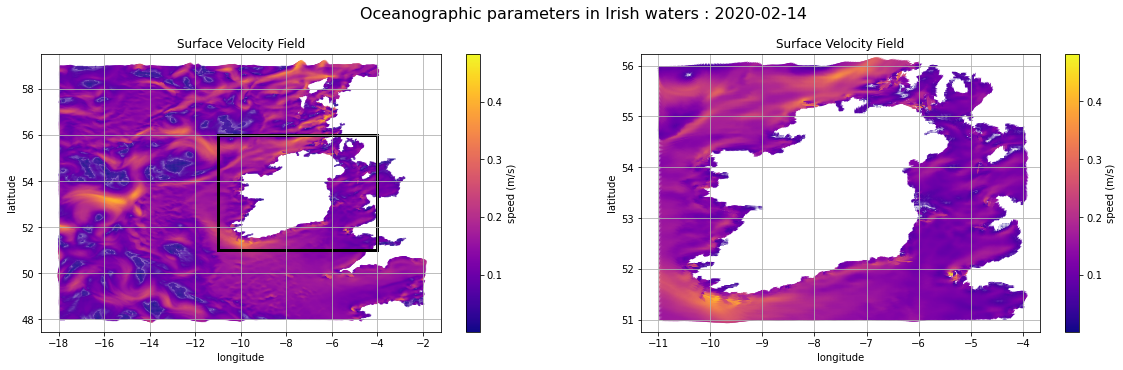

In [12]:
plt.subplots(figsize=(16, 5))
plt.suptitle("Oceanographic parameters in Irish waters : " + str(date_param), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# -----------------------------------------------------------------------------------
plt.subplot(1, 2, 1)

# Test sur 1 date
table = table_init.loc[(table_init[table_init.columns[0]] == date_param)]

# Meshgrid
x, y = table['longitude'], table['latitude']
  
# Directional vectors
u = table['sea_surface_x_velocity']
v = table['sea_surface_y_velocity']

# Normalization and color by parameter
param_color = table['speed']
norm = matplotlib.colors.Normalize()
norm.autoscale(param_color)
cm = matplotlib.cm.plasma #copper plasma viridis
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)

# Plotting Vector Field with QUIVER
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
plt.colorbar(sm,label='speed (m/s)')


rectangle = plt.Rectangle((-11,51), 7, 5, ec="black", fc='none', lw=3)
plt.gca().add_patch(rectangle)
plt.title('Surface Velocity Field')
plt.xlabel('longitude') 
plt.ylabel('latitude') 
plt.grid()

# -----------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
zoom = table_init.loc[(table_init[table_init.columns[0]] == date_param) & 
                      (table_init[table_init.columns[3]] > 51) & (table_init[table_init.columns[3]] < 56) & 
                      (table_init[table_init.columns[4]] >-11) & (table_init[table_init.columns[4]] < -4)]
# Meshgrid
x, y = zoom['longitude'], zoom['latitude']
  
# Directional vectors
u = zoom['sea_surface_x_velocity']
v = zoom['sea_surface_y_velocity']

# Normalization and color by parameter
param_color = zoom['speed'] #['speed']
norm = matplotlib.colors.Normalize()
norm.autoscale(param_color)
cm = matplotlib.cm.plasma #copper plasma viridis
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)

# Plotting Vector Field with QUIVER
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
plt.colorbar(sm,label='speed (m/s)') # param_color.columns.values table.columns[10][0]
plt.title('Surface Velocity Field')
plt.xlabel('longitude') 
plt.ylabel('latitude') 
plt.grid()
plt.savefig('OUTPUTS_FORMATION/P8_001_chps_vitesse.jpg',dpi=300)
plt.show()

## Découpage par Zones

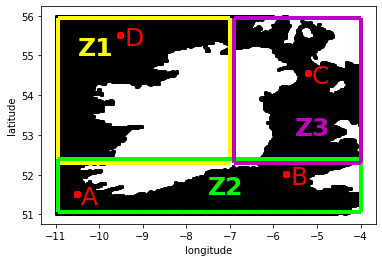

In [13]:
# plt.subplots(figsize=(16, 16))
# plt.subplot(3, 2, 1)
plt.rcParams["figure.figsize"] = [6, 4]
lat   = [51.5125 , 52.0125, 54.5625, 55.5125]
long  = [-10.5125, -5.7125, -5.2125, -9.5125]
pt  = ['A','B','C','D']
pos_4_point = pd.DataFrame()
for i,j,k in zip(lat,long,pt):  
    X, Y = zoom['longitude'], zoom['latitude']
    data   = table_init.loc[(table_init[table_init.columns[3]] == i) & (table_init[table_init.columns[4]] ==j)]
    pos_4_point  = pos_4_point.append(data)
    longi, lati = pos_4_point['longitude'], pos_4_point['latitude']
    plt.scatter(X, Y, s=2, c='k')
    plt.text(j+0.1,i-0.25, k,c='r', size=25)
    plt.scatter(longi,lati, s=35, c='r',marker="o")

plt.text(-10.5,55, 'Z1',c='yellow', size=25, weight='bold')
plt.hlines(y=52.3, xmin=-10.95, xmax=-7, linewidth=4, color = 'yellow')
plt.hlines(y=55.95, xmin=-10.95, xmax=-7, linewidth=4, color = 'yellow')
plt.vlines(x=-7, ymin=52.3, ymax = 55.95, linewidth=4, color='yellow')
plt.vlines(x=-10.95, ymin=52.3, ymax = 55.95, linewidth=4, color='yellow')

plt.text(-7.5,51.5, 'Z2',c='lime', size=25, weight='bold')
plt.hlines(y=52.4, xmin=-10.95, xmax=-4, linewidth=4, color = 'lime')
plt.hlines(y=51.05, xmin=-10.95, xmax=-4, linewidth=4, color = 'lime')
plt.vlines(x=-10.95, ymin=51.05, ymax = 52.4, linewidth=4, color='lime')
plt.vlines(x=-4., ymin=51.05, ymax = 52.4, linewidth=4, color='lime')

plt.text(-5.5,53, 'Z3',c='m', size=25, weight='bold')
plt.hlines(y=52.3, xmin=-6.9, xmax=-4, linewidth=4, color = 'm')
plt.hlines(y=55.95, xmin=-6.9, xmax=-4, linewidth=4, color = 'm')
plt.vlines(x=-6.9, ymin=52.3, ymax = 55.95, linewidth=4, color='m')
plt.vlines(x=-4 , ymin=52.3, ymax = 55.95, linewidth=4, color='m')
plt.xlabel('longitude') 
plt.ylabel('latitude') 
plt.savefig('OUTPUTS_FORMATION/P8_002_decoupage_Z.jpg',dpi=100)
plt.show()

In [14]:
# découpage en 3 zones (WEST, SOUTH, INSIDE)

ZG = table_init.loc[(table_init[table_init.columns[3]] > 51) & (table_init[table_init.columns[3]] < 56) & 
                    (table_init[table_init.columns[4]] >-11) & (table_init[table_init.columns[4]] < -4)]

Z1 = table_init.loc[(table_init[table_init.columns[3]] >52.25) & (table_init[table_init.columns[3]] <56)& 
                    (table_init[table_init.columns[4]] >-11) & (table_init[table_init.columns[4]] <-7)]

Z2 = table_init.loc[(table_init[table_init.columns[3]] <52.25) & (table_init[table_init.columns[3]] >51)&
                    (table_init[table_init.columns[4]] >-11) & (table_init[table_init.columns[4]] <-4)]

Z3 = table_init.loc[(table_init[table_init.columns[3]] >52.25) & (table_init[table_init.columns[3]] <56)&
                    (table_init[table_init.columns[4]] >-7) & (table_init[table_init.columns[4]] <-4)]

### Export GIF  /an à la même date

#### Velocity field

In [15]:
# vmin=0.0
# vmax=0.4
# # STEP 1 : sauvegarde de séquences img temporelles
# liste_date = ['2016-03-15','2017-03-15','2018-03-15','2019-03-15','2020-03-15','2021-03-15']
# save_P8    = ['P8_speed_1','P8_speed_2','P8_speed_3','P8_speed_4','P8_speed_5','P8_speed_6']
# for i,j in zip(liste_date,save_P8):
#     table = table_init.loc[(table_init[table_init.columns[0]] == i)]
#     x, y = table['longitude'], table['latitude']
#     u = table['sea_surface_x_velocity']
#     v = table['sea_surface_y_velocity']
#     param_color = table['speed'] 
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
#     cm = matplotlib.cm.plasma 
#     sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
#     plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
#     plt.colorbar(sm,label='speed (m/s)')
#     plt.title('Surface Velocity Field : '+str(i))
#     plt.xlabel('longitude') 
#     plt.ylabel('latitude') 
#     plt.grid()
#     plt.savefig(j+str('.jpg'),dpi=300)
#     plt.show()

# # STEP 2 : concaténation pour créer la séquence
# import imageio
# import os
# path = 'C:\\Users\\HP' 
# image_folder = os.fsencode(path)
# filenames = []
# for file in os.listdir(image_folder):
#     filename = os.fsdecode(file)
#     if filename.endswith( ('.jpg') ): #('.jpg', '.png', '.gif')
#         filenames.append(filename)
# images = list(map(lambda filename: imageio.imread(filename), filenames))
# imageio.mimsave(os.path.join('movie_speed.gif'), images, duration = 0.3) 

# STEP 3 : affichage du GIF en déscativant STEPS 1 & 2
from IPython.display import display, HTML
HTML('''<div style="display: flex; justify-content: row;"> <img src="movie_speed.gif"> </div>''')

#### Tsurface field

In [16]:
# vmin=7
# vmax=12
# # STEP 1 : sauvegarde de séquences img temporelles
# liste_date = ['2016-03-15','2017-03-15','2018-03-15','2019-03-15','2020-03-15','2021-03-15']
# save_P8    = ['P8_Tsurf_1','P8_Tsurf_2','P8_Tsurf_3','P8_Tsurf_4','P8_Tsurf_5','P8_Tsurf_6']
# for i,j in zip(liste_date,save_P8):
#     table = table_init.loc[(table_init[table_init.columns[0]] == i)]
#     x, y = table['longitude'], table['latitude']
#     u = table['sea_surface_x_velocity']
#     v = table['sea_surface_y_velocity']
#     param_color = table['sea_surface_temperature'] 
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
#     cm = matplotlib.cm.plasma 
#     sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
#     plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
# #     plt.scatter(x, y, color=cm(norm(param_color)),s=.75)
#     plt.colorbar(sm,label='T surface (°C)')
#     plt.title('Surface Temperature Field : '+str(i))
#     plt.xlabel('longitude') 
#     plt.ylabel('latitude') 
#     plt.grid()
#     plt.savefig(j+str('.jpg'),dpi=300)
#     plt.show()

# # STEP 2 : concaténation pour créer la séquence
# import imageio
# import os
# path = 'C:\\Users\\HP' 
# image_folder = os.fsencode(path)
# filenames = []
# for file in os.listdir(image_folder):
#     filename = os.fsdecode(file)
#     if filename.endswith( ('.jpg') ): #('.jpg', '.png', '.gif')
#         filenames.append(filename)
# images = list(map(lambda filename: imageio.imread(filename), filenames))
# imageio.mimsave(os.path.join('movie_Tsurf.gif'), images, duration = 0.3) 

# STEP 3 : affichage du GIF en déscativant STEPS 1 & 2
from IPython.display import display, HTML
HTML('''<div style="display: flex; justify-content: row;"> <img src="movie_Tsurf.gif"> </div>''')

#### Tsalinity field

In [17]:
# vmin=34
# vmax=35.5
# # STEP 1 : sauvegarde de séquences img temporelles
# liste_date = ['2016-03-15','2017-03-15','2018-03-15','2019-03-15','2020-03-15','2021-03-15']
# save_P8    = ['P8_Sal_1','P8_Sal_2','P8_Sal_3','P8_Sal_4','P8_Sal_5','P8_Sal_6']
# for i,j in zip(liste_date,save_P8):
#     table = table_init.loc[(table_init[table_init.columns[0]] == i)]
#     x, y = table['longitude'], table['latitude']
#     u = table['sea_surface_x_velocity']
#     v = table['sea_surface_y_velocity']
#     param_color = table['sea_surface_salinity'] 
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
#     cm = matplotlib.cm.plasma 
#     sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
#     plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
# #     plt.scatter(x, y, color=cm(norm(param_color)),s=.75)
#     plt.colorbar(sm,label='Salinity (PSU)')
#     plt.title('Surface Salinity Field : '+str(i))
#     plt.xlabel('longitude') 
#     plt.ylabel('latitude') 
#     plt.grid()
#     plt.savefig(j+str('.jpg'),dpi=300)
#     plt.show()

# # STEP 2 : concaténation pour créer la séquence
# import imageio
# import os
# path = 'C:\\Users\\HP' 
# image_folder = os.fsencode(path)
# filenames = []
# for file in os.listdir(image_folder):
#     filename = os.fsdecode(file)
#     if filename.endswith( ('.jpg') ): #('.jpg', '.png', '.gif')
#         filenames.append(filename)
# images = list(map(lambda filename: imageio.imread(filename), filenames))
# imageio.mimsave(os.path.join('movie_Sal.gif'), images, duration = 0.3) 

# STEP 3 : affichage du GIF en déscativant STEPS 1 & 2
from IPython.display import display, HTML
HTML('''<div style="display: flex; justify-content: row;"> <img src="movie_Sal.gif"> </div>''')

#### Tbottom field

In [18]:
# vmin=2
# vmax=12
# # STEP 1 : sauvegarde de séquences img temporelles
# liste_date = ['2016-03-15','2017-03-15','2018-03-15','2019-03-15','2020-03-15','2021-03-15']
# save_P8    = ['P8_Tbott_1','P8_Tbott_2','P8_Tbott_3','P8_Tbott_4','P8_Tbott_5','P8_Tbott_6']
# for i,j in zip(liste_date,save_P8):
#     table = table_init.loc[(table_init[table_init.columns[0]] == i)]
#     x, y = table['longitude'], table['latitude']
#     u = table['sea_surface_x_velocity']
#     v = table['sea_surface_y_velocity']
#     param_color = table['sea_bottom_temperature'] 
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
#     cm = matplotlib.cm.plasma 
#     sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
# #     plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
#     plt.scatter(x, y, color=cm(norm(param_color)),s=.75)
#     plt.colorbar(sm,label='T fond (°C)')
#     plt.title('Bottom Temperature Field : '+str(i))
#     plt.xlabel('longitude') 
#     plt.ylabel('latitude') 
#     plt.grid()
#     plt.savefig(j+str('.jpg'),dpi=300)
#     plt.show()

# # STEP 2 : concaténation pour créer la séquence
# import imageio
# import os
# path = 'C:\\Users\\HP' 
# image_folder = os.fsencode(path)
# filenames = []
# for file in os.listdir(image_folder):
#     filename = os.fsdecode(file)
#     if filename.endswith( ('.jpg') ): #('.jpg', '.png', '.gif')
#         filenames.append(filename)
# images = list(map(lambda filename: imageio.imread(filename), filenames))
# imageio.mimsave(os.path.join('movie_Tbott.gif'), images, duration = 0.3) 

# STEP 3 : affichage du GIF en déscativant STEPS 1 & 2
from IPython.display import display, HTML
HTML('''<div style="display: flex; justify-content: row;"> <img src="movie_Tbott.gif"> </div>''')

#### Profondeur couche de mélange

In [19]:
# vmin=1
# vmax=895
# # STEP 1 : sauvegarde de séquences img temporelles
# # liste_date = table_init[['date']].drop_duplicates()
# liste_date = ['2020-01-15','2020-02-14','2020-03-15','2020-04-15','2020-05-15','2020-06-15',
#                  '2020-07-15','2020-08-15','2020-09-15','2020-10-15','2020-11-15','2020-12-15']
# # save_P8    = ['P8_Tbott_1','P8_Tbott_2','P8_Tbott_3','P8_Tbott_4','P8_Tbott_5','P8_Tbott_6']
# for i in liste_date:
#     table = table_init.loc[(table_init[table_init.columns[0]] == i)]
#     x, y = table['longitude'], table['latitude']
#     u = table['sea_surface_x_velocity']
#     v = table['sea_surface_y_velocity']
#     param_color = table['mixed_layer_depth'] 
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
#     cm = matplotlib.cm.plasma_r 
#     sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
# #     plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=cm(norm(param_color))) 
#     plt.scatter(x, y, color=cm(norm(param_color)),s=.75)
#     plt.colorbar(sm,label='T fond (°C)')
#     plt.title('Mixed Layer Depth (MLD) Field : '+str(i))
#     plt.xlabel('longitude') 
#     plt.ylabel('latitude') 
#     plt.grid()
#     plt.savefig(i+str('.jpg'),dpi=300)
#     plt.show()

# # STEP 2 : concaténation pour créer la séquence
# import imageio
# import os
# path = 'C:\\Users\\HP' 
# image_folder = os.fsencode(path)
# filenames = []
# for file in os.listdir(image_folder):
#     filename = os.fsdecode(file)
#     if filename.endswith( ('.jpg') ): #('.jpg', '.png', '.gif')
#         filenames.append(filename)
# images = list(map(lambda filename: imageio.imread(filename), filenames))
# imageio.mimsave(os.path.join('movie_Profondeur.gif'), images, duration = 0.3) 

# STEP 3 : affichage du GIF en déscativant STEPS 1 & 2
from IPython.display import display, HTML
HTML('''<div style="display: flex; justify-content: row;"> <img src="movie_Profondeur.gif"> </div>''')

## Evolutions temporelles

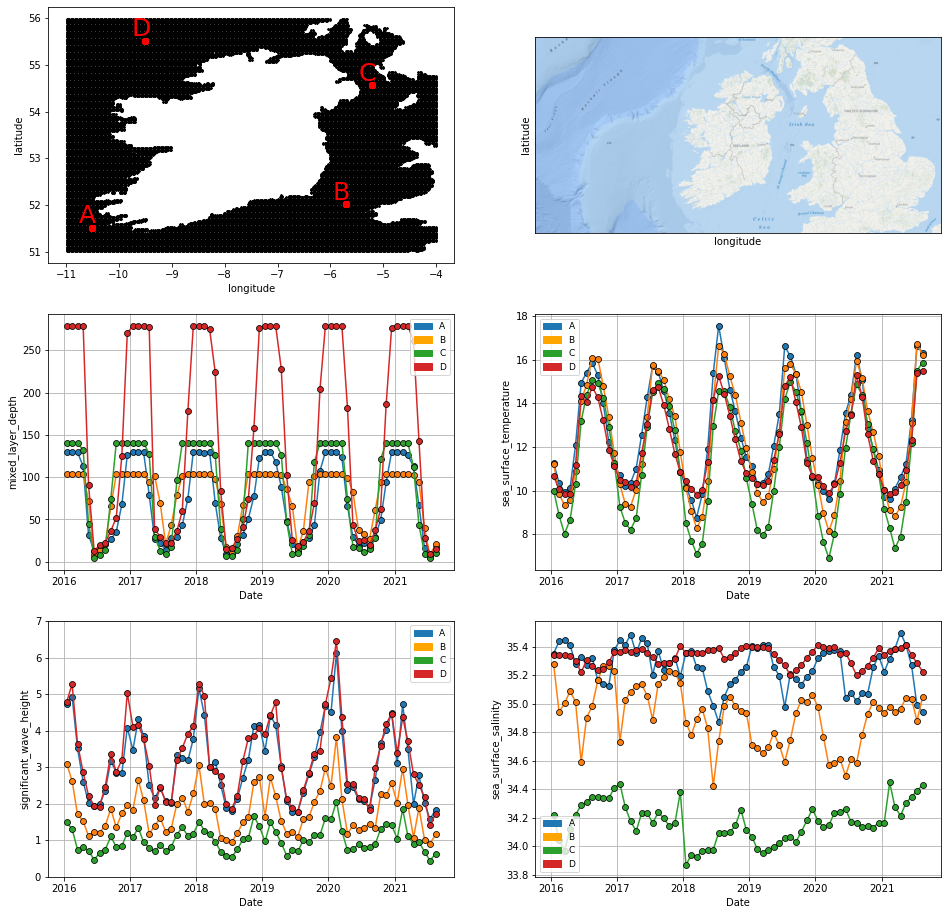

In [20]:
plt.subplots(figsize=(16, 16))
# plt.suptitle("Oceanographic parameters in Irish waters", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.85,hspace=.25, wspace=.1)
# ----------------------------------------------------------------------------------- 4 pts géo
plt.subplot(3, 2, 1)
lat   = [51.5125 , 52.0125, 54.5625, 55.5125]
long  = [-10.5125, -5.7125, -5.2125, -9.5125]
pt  = ['A','B','C','D']
pos_4_point = pd.DataFrame()
for i,j,k in zip(lat,long,pt):  
    X, Y = zoom['longitude'], zoom['latitude']
    data   = table_init.loc[(table_init[table_init.columns[3]] == i) & (table_init[table_init.columns[4]] ==j)]
    pos_4_point  = pos_4_point.append(data)
    longi, lati = pos_4_point['longitude'], pos_4_point['latitude']
    plt.scatter(X, Y, s=1, c='k')
    plt.text(j-0.25,i+0.1, k,c='r', size=25)
    plt.scatter(longi,lati, s=35, c='r',marker="o")
plt.xlabel('longitude') 
plt.ylabel('latitude') 

# ----------------------------------------------------------------------------------- Image
plt.subplot(3, 2, 2)
from PIL import Image
img1 = Image.open('INPUTS_FORMATION/P8_capture_arcgis.jpg') #or P8_capture_arcgis_zoom.jpg
plt.imshow(img1)
plt.xlabel('longitude') 
plt.ylabel('latitude') 
plt.xticks([]) 
plt.yticks([])

# ----------------------------------------------------------------------------------- Plot paramètre x temporel Tsurf
plt.subplot(3, 2, 4)
points=[]
evo_i = pd.DataFrame()
for i,j in zip(lat,long):
    data    = table_init.loc[(table_init[table_init.columns[3]]==i) & (table_init[table_init.columns[4]]==j)]
    evo_i   = evo_i.append(data)
for i in range(len(evo_i)):
    evo_i.loc[evo_i['latitude'] == lat[0], 'points'] = pt[0]
    evo_i.loc[evo_i['latitude'] == lat[1], 'points'] = pt[1]
    evo_i.loc[evo_i['latitude'] == lat[2], 'points'] = pt[2]
    evo_i.loc[evo_i['latitude'] == lat[3], 'points'] = pt[3]
# evo_i['points'] = 'pt_' + evo_i['points'].astype(str)
sns.lineplot(x=evo_i["date"], y=evo_i["sea_surface_temperature"],marker="o",mec="k",ci=None,hue=evo_i['points']) #palette="hot"
plt.xlabel('Date') 
plt.ylabel('sea_surface_temperature') 
plt.grid()
my_colors = {pt[0]:'tab:blue',pt[1]:'orange',pt[2]:'tab:green',pt[3]:'tab:red'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=9)#, bbox_to_anchor=(1.01, .65)
# plt.ylim(9,11)

# ----------------------------------------------------------------------------------- Plot heatmap Temp
plt.subplot(3, 2, 3)
points=[]
evo_i = pd.DataFrame()
for i,j in zip(lat,long):
    data    = table_init.loc[(table_init[table_init.columns[3]]==i) & (table_init[table_init.columns[4]]==j)]
    evo_i   = evo_i.append(data)
for i in range(len(evo_i)):
    evo_i.loc[evo_i['latitude'] == lat[0], 'points'] = pt[0]
    evo_i.loc[evo_i['latitude'] == lat[1], 'points'] = pt[1]
    evo_i.loc[evo_i['latitude'] == lat[2], 'points'] = pt[2]
    evo_i.loc[evo_i['latitude'] == lat[3], 'points'] = pt[3]
# evo_i['points'] = 'pt_' + evo_i['points'].astype(str)
sns.lineplot(x=evo_i["date"], y=evo_i["mixed_layer_depth"],marker="o",mec="k",ci=None,hue=evo_i['points']) #palette="hot"
plt.xlabel('Date') 
plt.ylabel('mixed_layer_depth') 
plt.grid()
my_colors = {pt[0]:'tab:blue',pt[1]:'orange',pt[2]:'tab:green',pt[3]:'tab:red'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=9)#, bbox_to_anchor=(1.01, .65)
# plt.ylim(9,11)

# ----------------------------------------------------------------------------------- Plot heatmap Salinity
plt.subplot(3, 2, 5)
points=[]
evo_i = pd.DataFrame()
for i,j in zip(lat,long):
    data    = table_init.loc[(table_init[table_init.columns[3]]==i) & (table_init[table_init.columns[4]]==j)]
    evo_i   = evo_i.append(data)
for i in range(len(evo_i)):
    evo_i.loc[evo_i['latitude'] == lat[0], 'points'] = pt[0]
    evo_i.loc[evo_i['latitude'] == lat[1], 'points'] = pt[1]
    evo_i.loc[evo_i['latitude'] == lat[2], 'points'] = pt[2]
    evo_i.loc[evo_i['latitude'] == lat[3], 'points'] = pt[3]
# evo_i['points'] = 'pt_' + evo_i['points'].astype(str)
sns.lineplot(x=evo_i["date"], y=evo_i["significant_wave_height"],marker="o",mec="k",ci=None,hue=evo_i['points']) #palette="hot"
plt.xlabel('Date') 
plt.ylabel('significant_wave_height') 
plt.grid()
my_colors = {pt[0]:'tab:blue',pt[1]:'orange',pt[2]:'tab:green',pt[3]:'tab:red'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=9)#, bbox_to_anchor=(1.01, .65)
plt.ylim(0,7)

# ----------------------------------------------------------------------------------- Plot paramètre x temporel Salinity
plt.subplot(3, 2, 6)
points=[]
evo_i = pd.DataFrame()
for i,j in zip(lat,long):
    data    = table_init.loc[(table_init[table_init.columns[3]]==i) & (table_init[table_init.columns[4]]==j)]
    evo_i   = evo_i.append(data)
for i in range(len(evo_i)):
    evo_i.loc[evo_i['latitude'] == lat[0], 'points'] = pt[0]
    evo_i.loc[evo_i['latitude'] == lat[1], 'points'] = pt[1]
    evo_i.loc[evo_i['latitude'] == lat[2], 'points'] = pt[2]
    evo_i.loc[evo_i['latitude'] == lat[3], 'points'] = pt[3]
# evo_i['points'] = 'pt_' + evo_i['points'].astype(str)
sns.lineplot(x=evo_i["date"], y=evo_i["sea_surface_salinity"],marker="o",mec="k",ci=None,hue=evo_i['points']) #palette="hot"
plt.xlabel('Date') 
plt.ylabel('sea_surface_salinity') 
plt.grid()
my_colors = {pt[0]:'tab:blue',pt[1]:'orange',pt[2]:'tab:green',pt[3]:'tab:red'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='lower left',fontsize=9)#, bbox_to_anchor=(1.01, .65)
plt.savefig('OUTPUTS_FORMATION/P8_003_multiplots_lines_map.jpg',dpi=300)
plt.show()

## Export table

In [21]:
# table_init.to_csv("OUTPUTS_FORMATION/exports_tables/table_cleaned.csv", index = False)

## Prédictions T_surface par Holt-Winters

### Decomposition Statsmodels

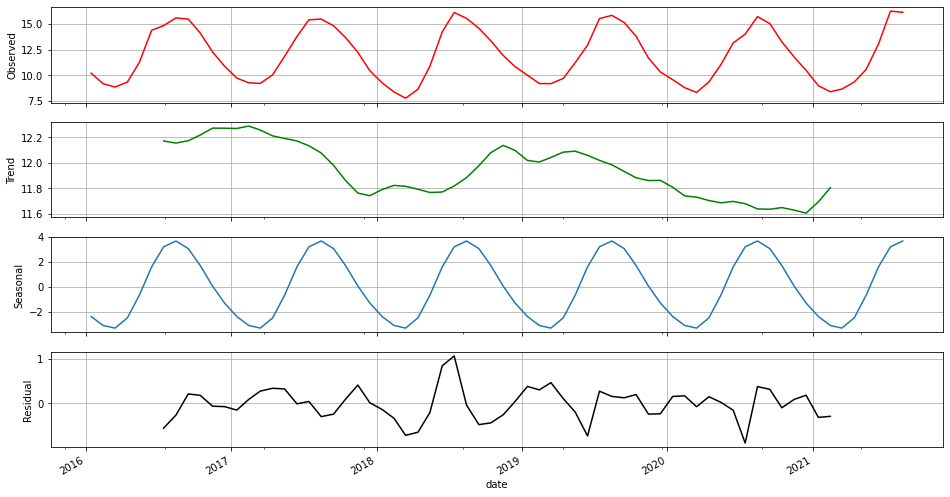

In [259]:
import statsmodels.api as sm

g = ZG.groupby(['date']).agg({'sea_surface_temperature':'mean'})
X = g['sea_surface_temperature']

modelG_Tsurf = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)

# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
modelG_Tsurf.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
modelG_Tsurf.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
modelG_Tsurf.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
modelG_Tsurf.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_004_decomposition_ZG.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'sea_surface_temperature': g["sea_surface_temperature"].values,
#                             'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': modelG_Tsurf.trend.values,
                            'seasonal': modelG_Tsurf.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': modelG_Tsurf.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage expnonentiel

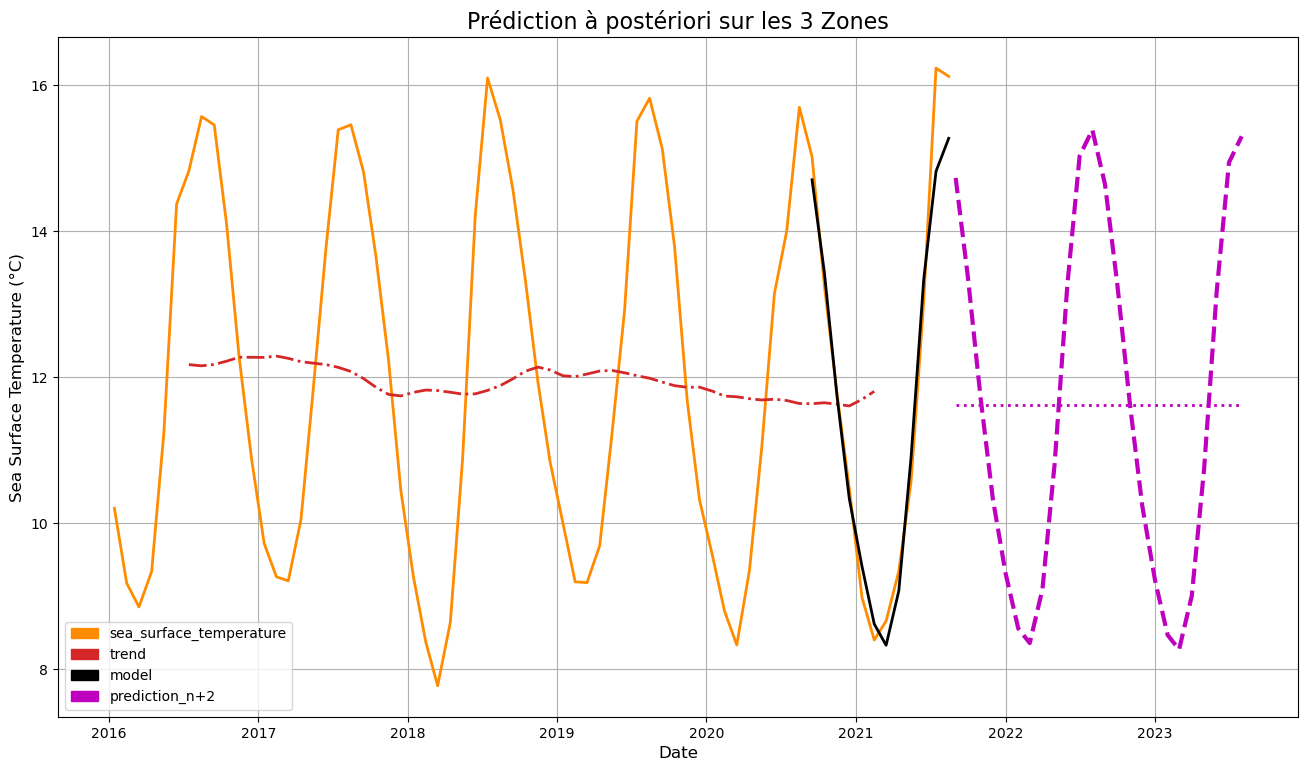

In [270]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1=ExponentialSmoothing(train['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1=model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_temperature'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.plot(ind_2022, [pred_np1_HW.mean()]*24,                 lw=2, c='m',ls=':')
ax.set_title("Prédiction à postériori sur les 3 Zones",fontsize=16)
my_colors = {"sea_surface_temperature":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Temperature (°C)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_004_pred_ZG.jpg',dpi=300)
plt.show()

### Metrics

In [158]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_temperature'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9867
mae       0.4018
mape      0.0322
me        0.1577
mpe       0.0101
rmse      0.5390

### Analyse bruit & résidus

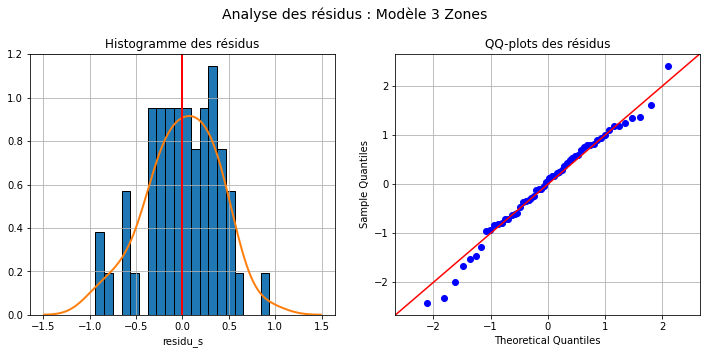

ShapiroResult(statistic=0.9857586622238159, pvalue=0.7479040622711182)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

      lb_stat  lb_pvalue
12  48.721919   0.000002
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [159]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle 3 Zones", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_004_resid_ZG.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[12], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 1

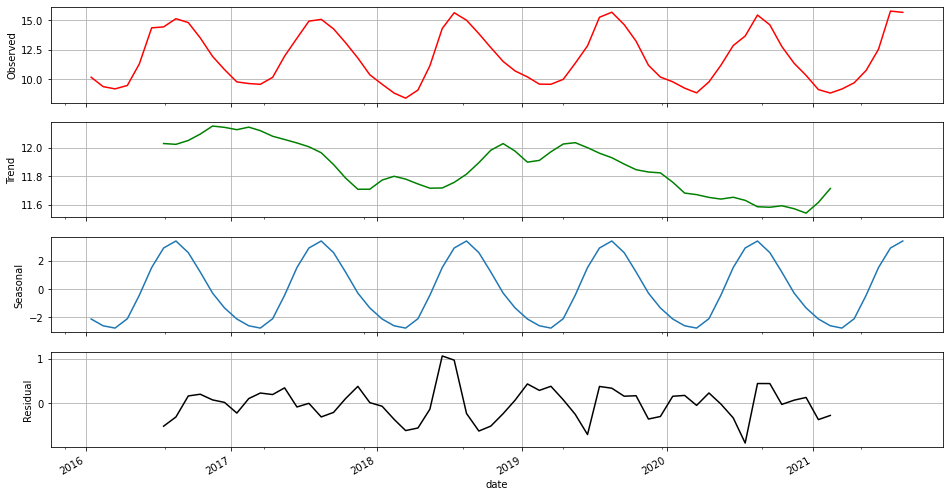

In [160]:
import statsmodels.api as sm

g = Z1.groupby(['date']).agg({'sea_surface_temperature':'mean'})
X = g['sea_surface_temperature']

model1_Tsurf = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model1_Tsurf.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model1_Tsurf.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model1_Tsurf.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model1_Tsurf.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_005_decomposition_Z1.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'sea_surface_temperature': g["sea_surface_temperature"].values,
#                             'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': model1_Tsurf.trend.values,
                            'seasonal': model1_Tsurf.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model1_Tsurf.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

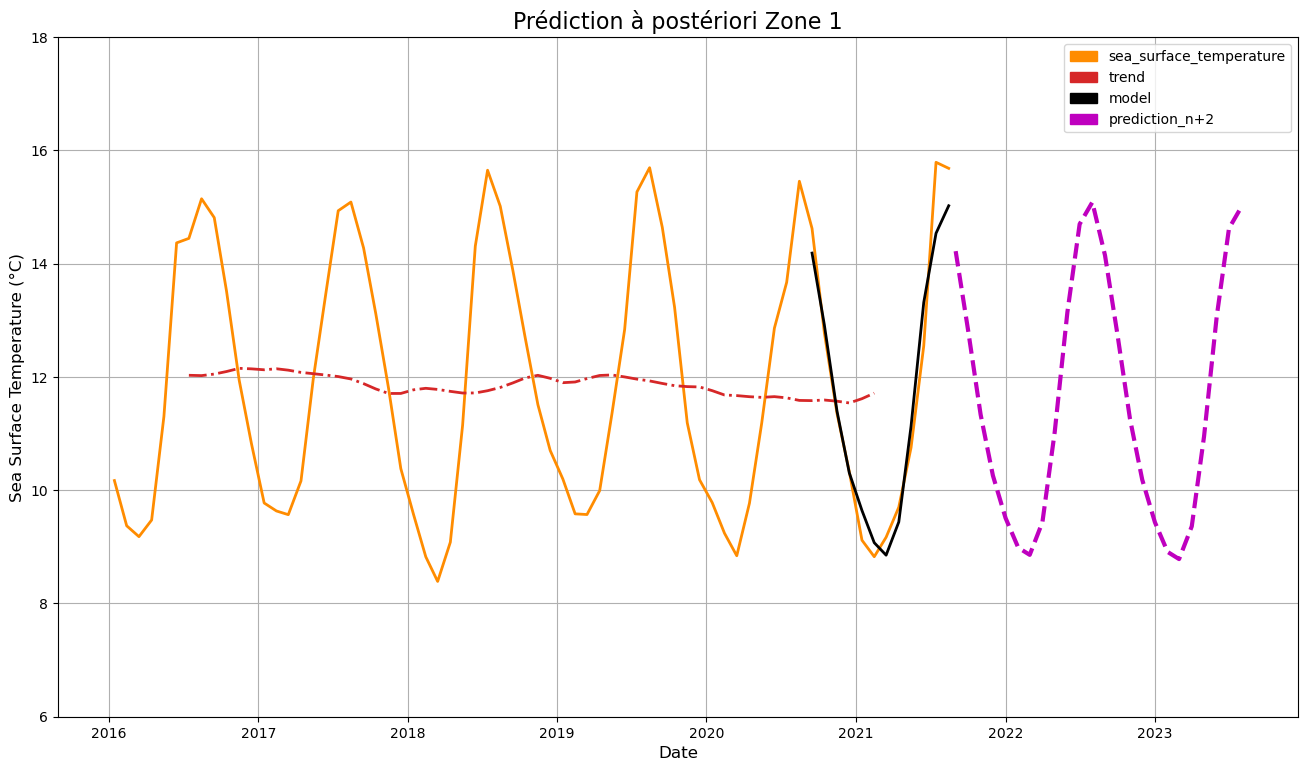

In [161]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_temperature'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 1",fontsize=16)
my_colors = {"sea_surface_temperature":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Temperature (°C)",fontsize=12)
ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_005_pred_Z1.jpg',dpi=300)
plt.show()

### Metrics

In [162]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_temperature'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9804
mae       0.4202
mape      0.0342
me        0.0709
mpe       0.0032
rmse      0.5364

### Analyse bruit & résidus

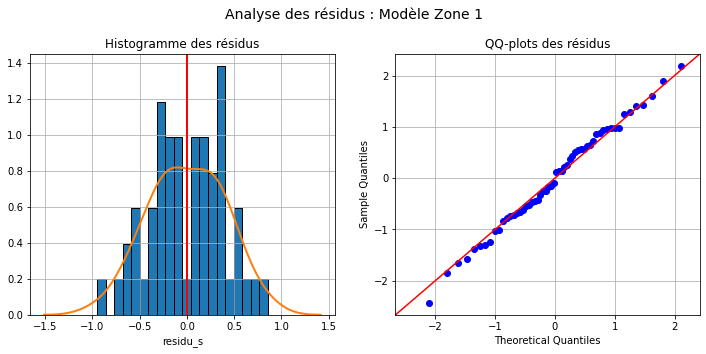

ShapiroResult(statistic=0.9908235669136047, pvalue=0.9464613795280457)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

     lb_stat  lb_pvalue
6  13.118826   0.041187
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [163]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 1", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_005_resid_Z1.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 2

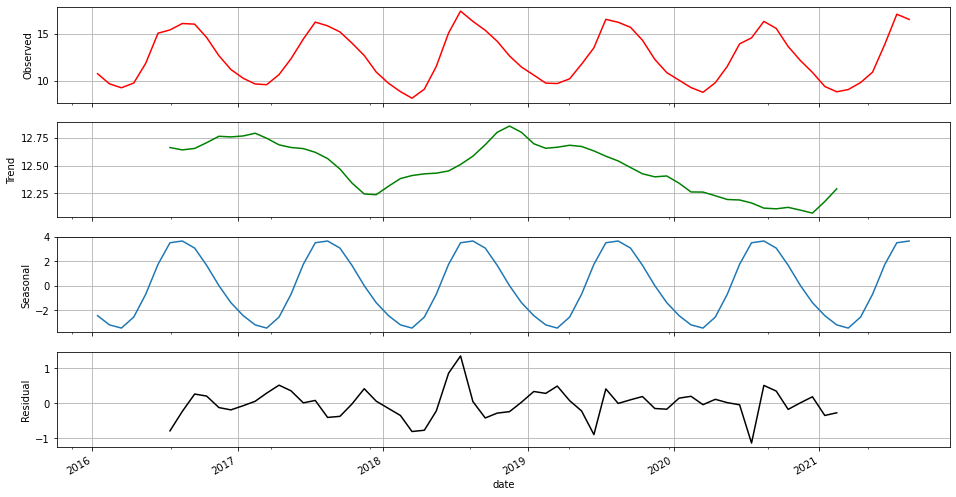

In [164]:
import statsmodels.api as sm

g = Z2.groupby(['date']).agg({'sea_surface_temperature':'mean'})
X = g['sea_surface_temperature']

model2_Tsurf = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model2_Tsurf.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model2_Tsurf.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model2_Tsurf.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model2_Tsurf.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_006_decomposition_Z2.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'sea_surface_temperature': g["sea_surface_temperature"].values,
#                             'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': model2_Tsurf.trend.values,
                            'seasonal': model2_Tsurf.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model2_Tsurf.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

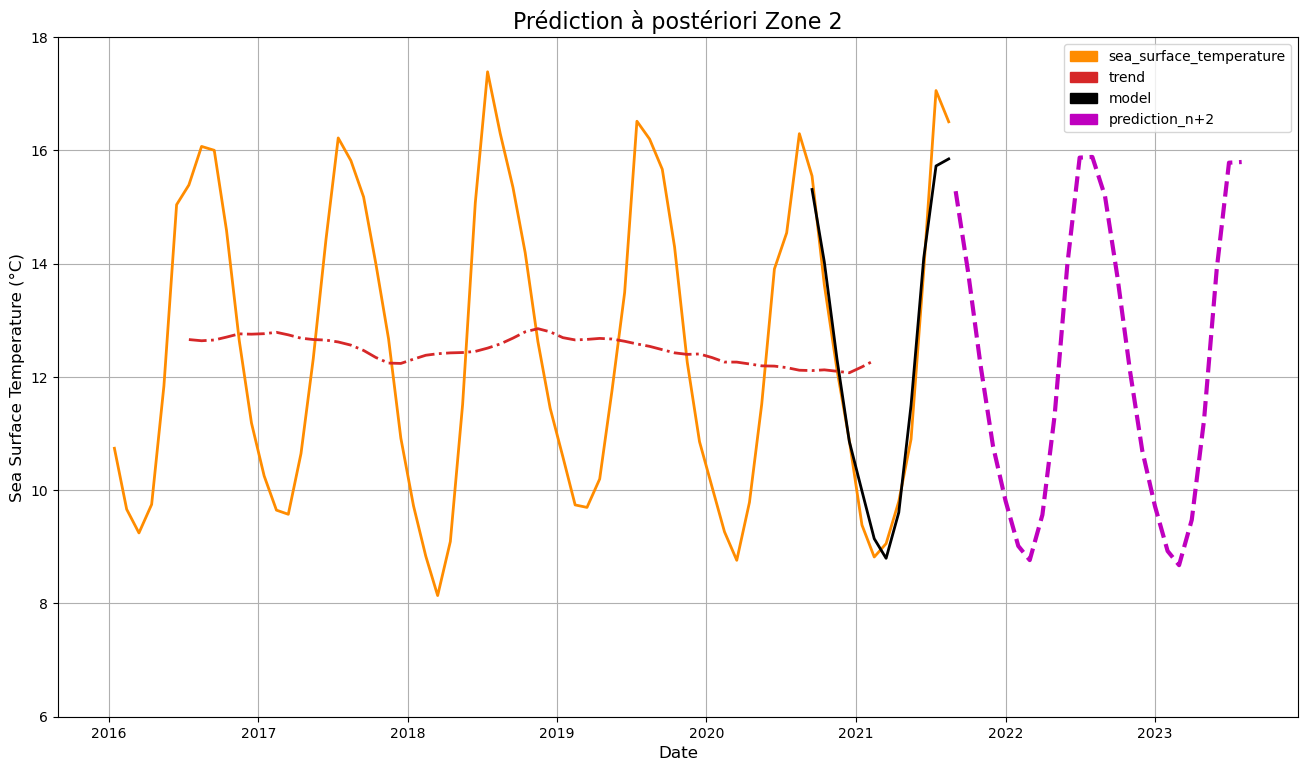

In [165]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_temperature'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 2",fontsize=16)
my_colors = {"sea_surface_temperature":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Temperature (°C)",fontsize=12)
ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_006_pred_Z2.jpg',dpi=300)
plt.show()

### Metrics

In [166]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_temperature'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9864
mae       0.4187
mape      0.0333
me        0.0304
mpe      -0.0012
rmse      0.5349

### Analyse bruit & résidus

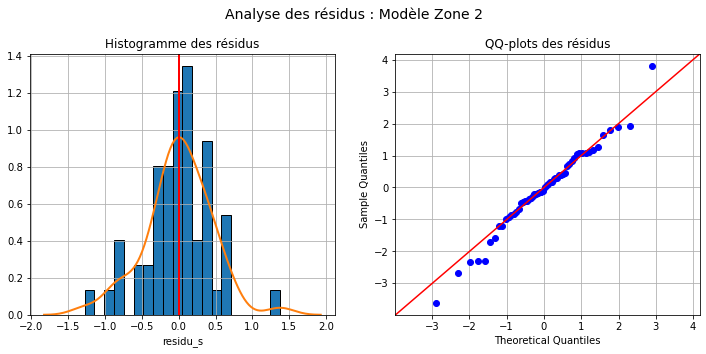

ShapiroResult(statistic=0.9741687774658203, pvalue=0.27079978585243225)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  8.612534    0.19657
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [167]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 2", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_006_resid_Z2.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 3

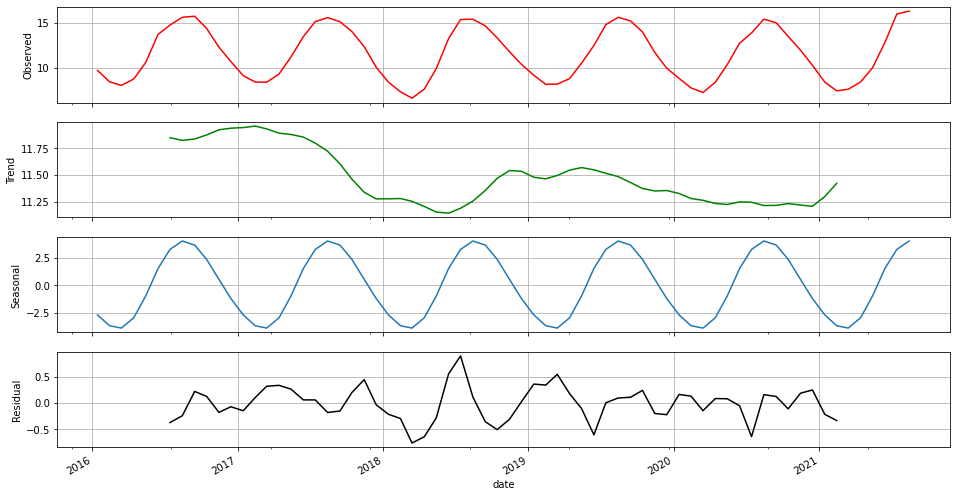

In [168]:
import statsmodels.api as sm

g = Z3.groupby(['date']).agg({'sea_surface_temperature':'mean'})
X = g['sea_surface_temperature']

model3_Tsurf = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model3_Tsurf.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model3_Tsurf.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model3_Tsurf.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model3_Tsurf.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_007_decomposition_Z3.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'sea_surface_temperature': g["sea_surface_temperature"].values,
#                             'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': model3_Tsurf.trend.values,
                            'seasonal': model3_Tsurf.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model3_Tsurf.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

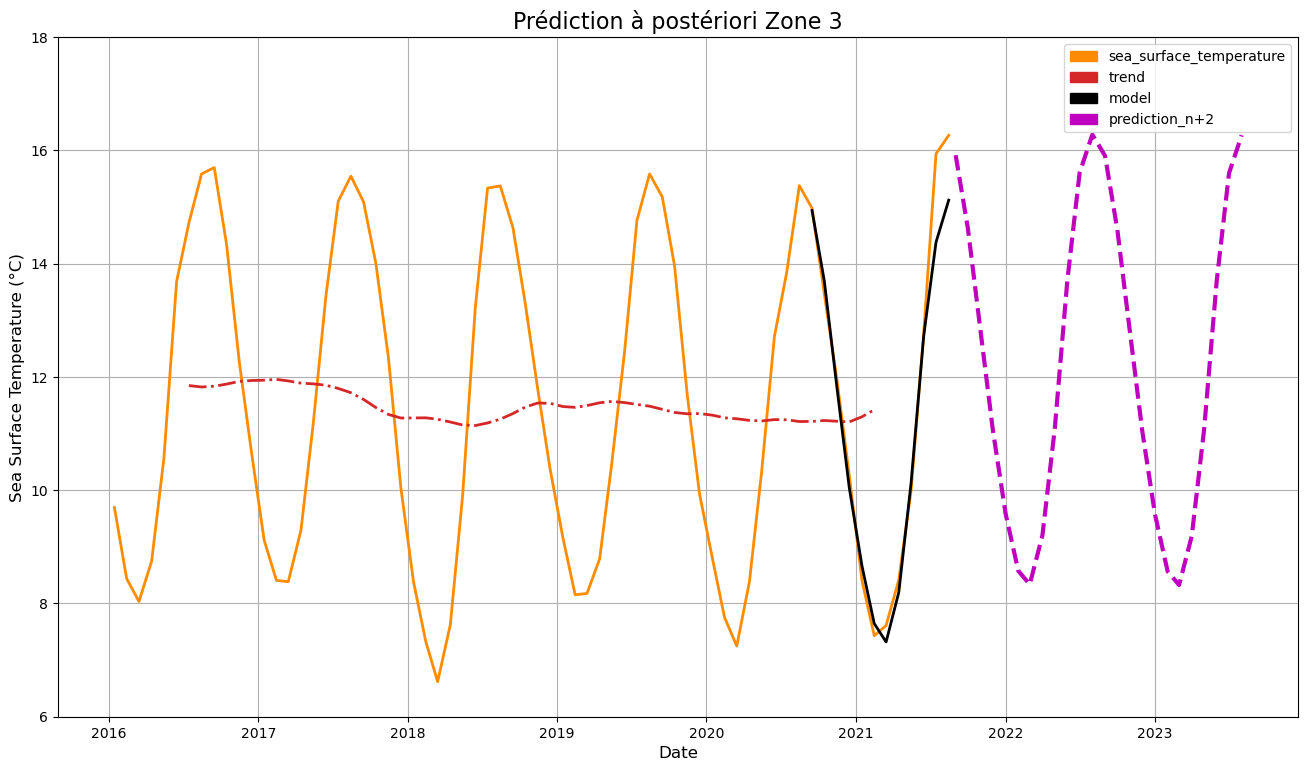

In [169]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_temperature'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_temperature'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 3",fontsize=16)
my_colors = {"sea_surface_temperature":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Temperature (°C)",fontsize=12)
ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_007_pred_Z3.jpg',dpi=300)
plt.show()

### Metrics

In [170]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_temperature'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9883
mae       0.3756
mape      0.0302
me        0.2363
mpe       0.0170
rmse      0.5871

### Analyse bruit & résidus

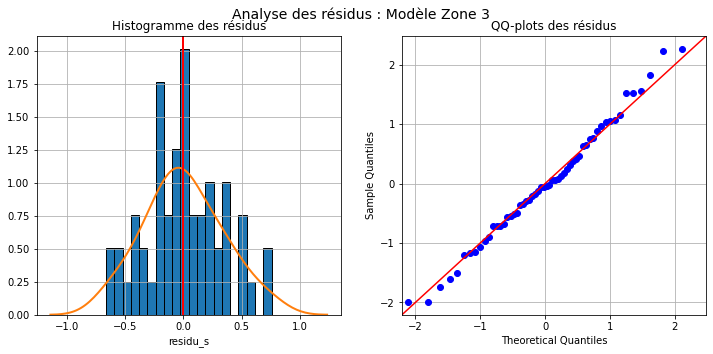

ShapiroResult(statistic=0.9877045750617981, pvalue=0.8372772336006165)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  6.952613   0.325252
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [171]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 3", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_007_resid_Z3.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition RESUME

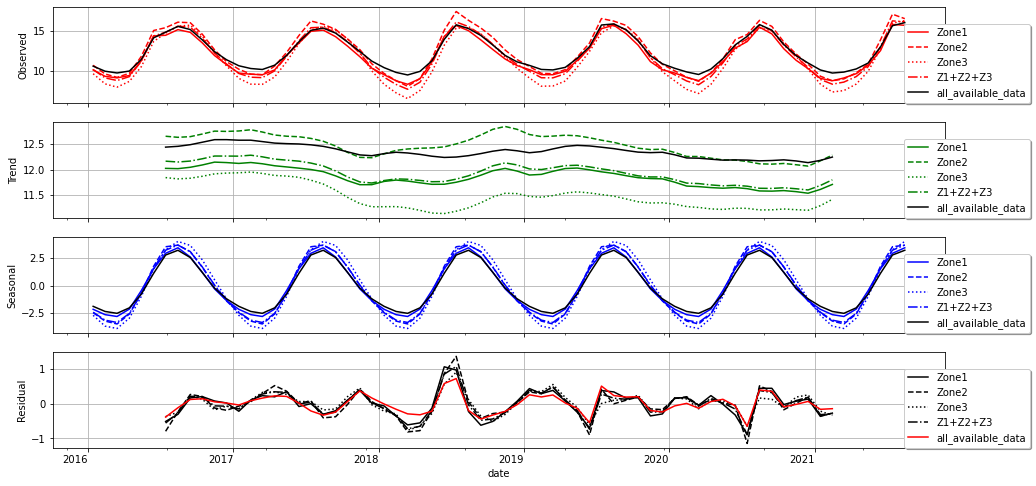

In [172]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

g = table_init.groupby(['date']).agg({'sea_surface_temperature':'mean'})
X = g['sea_surface_temperature']
model_all_Tsurf = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)

model1_Tsurf.observed.plot(ax=axes[0], legend=True, color='r', ls='-')
model2_Tsurf.observed.plot(ax=axes[0], legend=True, color='r', ls='--')
model3_Tsurf.observed.plot(ax=axes[0], legend=True, color='r', ls=':')
modelG_Tsurf.observed.plot(ax=axes[0], legend=True, color='r', ls='-.')
model_all_Tsurf.observed.plot(ax=axes[0], legend=True, color='k', ls='-')

axes[0].set_ylabel('Observed')
axes[0].grid()
import matplotlib.lines as mlines
colors = {'Zone1':'r','Zone2':'r','Zone3':'r','Z1+Z2+Z3':'r','all_available_data':'k'} 
style  = {'Zone1':'-','Zone2':'--','Zone3':':','Z1+Z2+Z3':'-.','all_available_data':'-'} 
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[0].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
# axes[0].set_ylim(5, 20)

model1_Tsurf.trend.plot(ax=axes[1], legend=True, color='g', ls='-')
model2_Tsurf.trend.plot(ax=axes[1], legend=True, color='g', ls='--')
model3_Tsurf.trend.plot(ax=axes[1], legend=True, color='g', ls=':')
modelG_Tsurf.trend.plot(ax=axes[1], legend=True, color='g', ls='-.')
model_all_Tsurf.trend.plot(ax=axes[1], legend=True, color='k', ls='-')

axes[1].set_ylabel('Trend')
axes[1].grid()
colors = {'Zone1':'g','Zone2':'g','Zone3':'g','Z1+Z2+Z3':'g','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[1].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
# axes[1].set_ylim(10, 14)

model1_Tsurf.seasonal.plot(ax=axes[2], legend=True, color='b',ls='-')
model2_Tsurf.seasonal.plot(ax=axes[2], legend=True, color='b',ls='--')
model3_Tsurf.seasonal.plot(ax=axes[2], legend=True, color='b',ls=':')
modelG_Tsurf.seasonal.plot(ax=axes[2], legend=True, color='b', ls='-.')
model_all_Tsurf.seasonal.plot(ax=axes[2], legend=True, color='k', ls='-')

axes[2].set_ylabel('Seasonal')
axes[2].grid()
colors = {'Zone1':'b','Zone2':'b','Zone3':'b','Z1+Z2+Z3':'b','all_available_data':'k'}  
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[2].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))

model1_Tsurf.resid.plot(ax=axes[3], legend=True, color='k',ls='-')
model2_Tsurf.resid.plot(ax=axes[3], legend=True, color='k',ls='--')
model3_Tsurf.resid.plot(ax=axes[3], legend=True, color='k',ls=':')
modelG_Tsurf.resid.plot(ax=axes[3], legend=True, color='k',ls='-.')
model_all_Tsurf.resid.plot(ax=axes[3], legend=True, color='r', ls='-')

axes[3].set_ylabel('Residual')
axes[3].grid()
# axes[3].set_ylim(-4.5, 4.5)

colors = {'Zone1':'k','Zone2':'k','Zone3':'k','Z1+Z2+Z3':'k','all_available_data':'r'}  
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[3].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
plt.xticks(rotation = 0)
plt.savefig('OUTPUTS_FORMATION/P8_007_decompo_RESUME_TSURF.jpg',dpi=300)
plt.show()

## Prédictions Salinity par Holt-Winters

### Decomposition Statsmodels

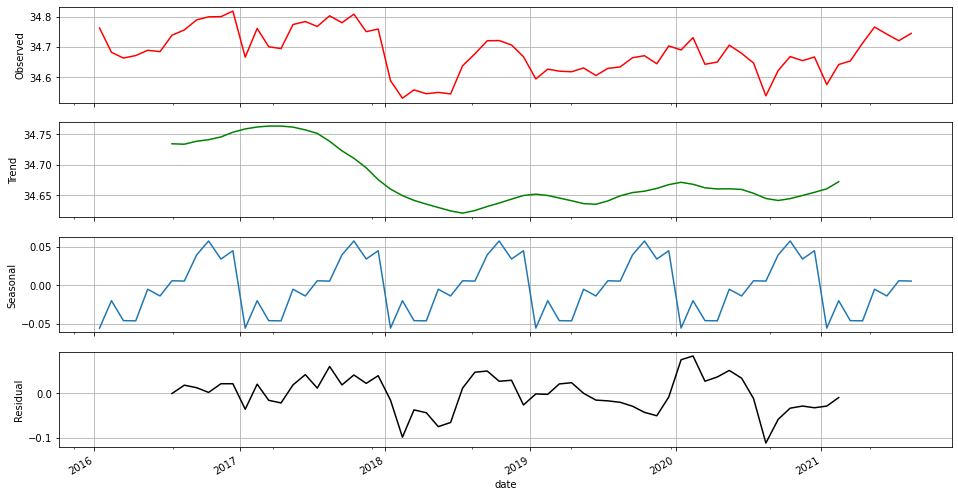

In [173]:
import statsmodels.api as sm

g = ZG.groupby(['date']).agg({'sea_surface_salinity':'mean'})
X = g['sea_surface_salinity']

modelG_Sal = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
modelG_Sal.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
modelG_Sal.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
modelG_Sal.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
modelG_Sal.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_004_decomposition_ZG_SAL.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
#                             'sea_surface_temperature': g["sea_surface_temperature"].values,
                            'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': modelG_Sal.trend.values,
                            'seasonal': modelG_Sal.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': modelG_Sal.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage expnonentiel

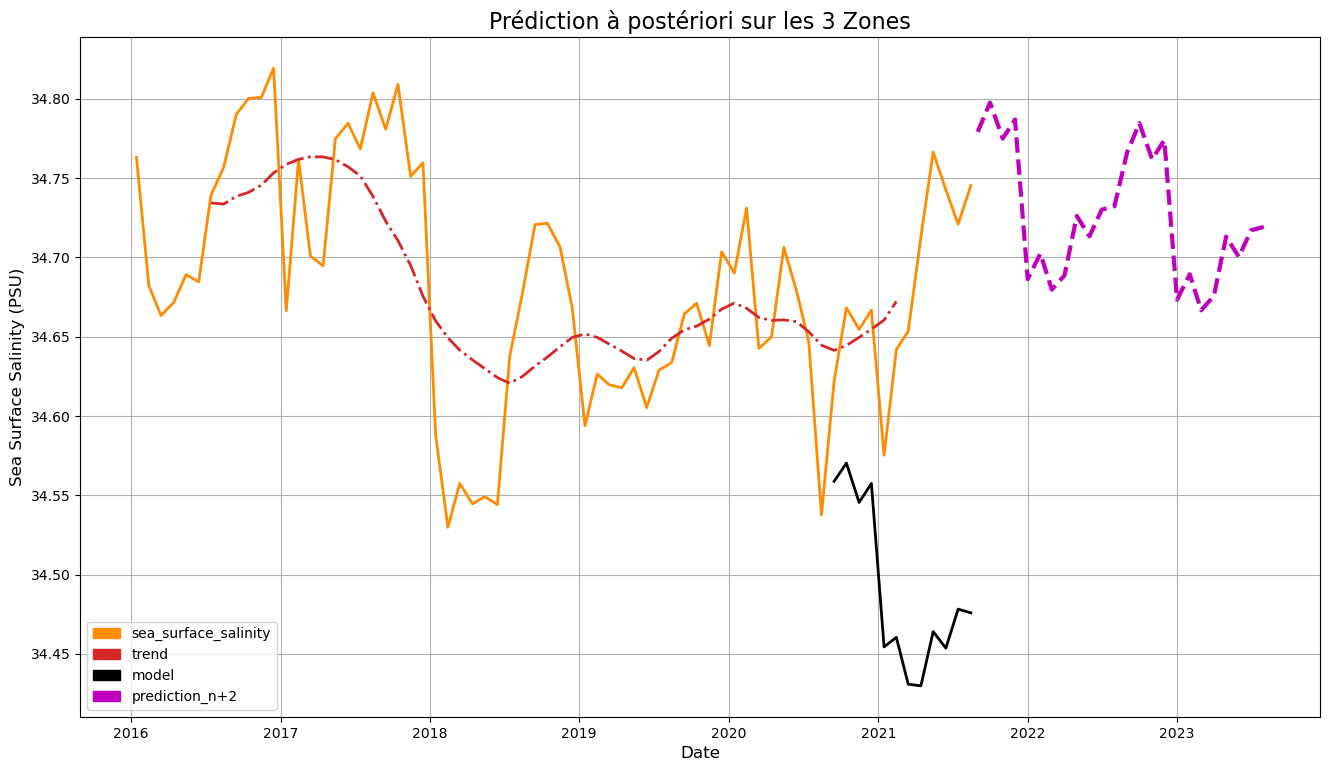

In [174]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_salinity'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori sur les 3 Zones",fontsize=16)
my_colors = {"sea_surface_salinity":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Salinity (PSU)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_004_pred_ZG_SAL.jpg',dpi=300)
plt.show()

### Metrics

In [175]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_salinity'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr     -0.2640
mae       0.1909
mape      0.0055
me        0.1909
mpe       0.0055
rmse      0.2084

### Analyse bruit & résidus

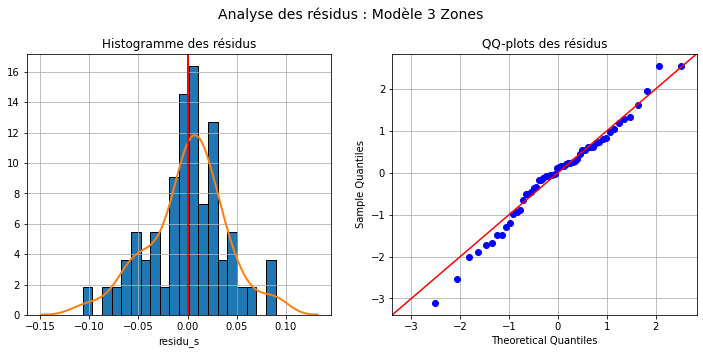

ShapiroResult(statistic=0.9795580506324768, pvalue=0.4569804072380066)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

      lb_stat  lb_pvalue
12  12.696063   0.391514
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [176]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle 3 Zones", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_004_resid_ZG_SAL.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[12], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 1

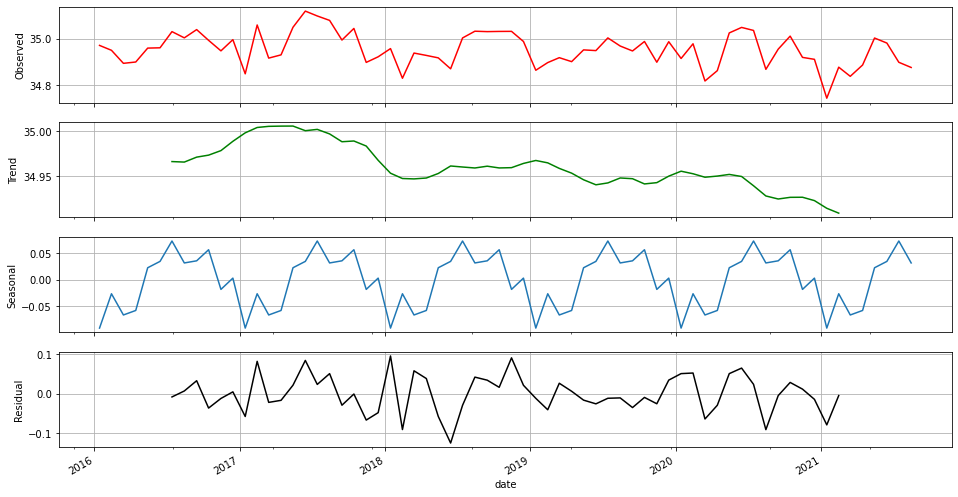

In [177]:
import statsmodels.api as sm

g = Z1.groupby(['date']).agg({'sea_surface_salinity':'mean'})
X = g['sea_surface_salinity']

model1_Sal = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model1_Sal.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model1_Sal.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model1_Sal.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model1_Sal.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_005_decomposition_Z1_SAL.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
#                             'sea_surface_temperature': g["sea_surface_temperature"].values,
                            'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': model1_Sal.trend.values,
                            'seasonal': model1_Sal.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model1_Sal.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

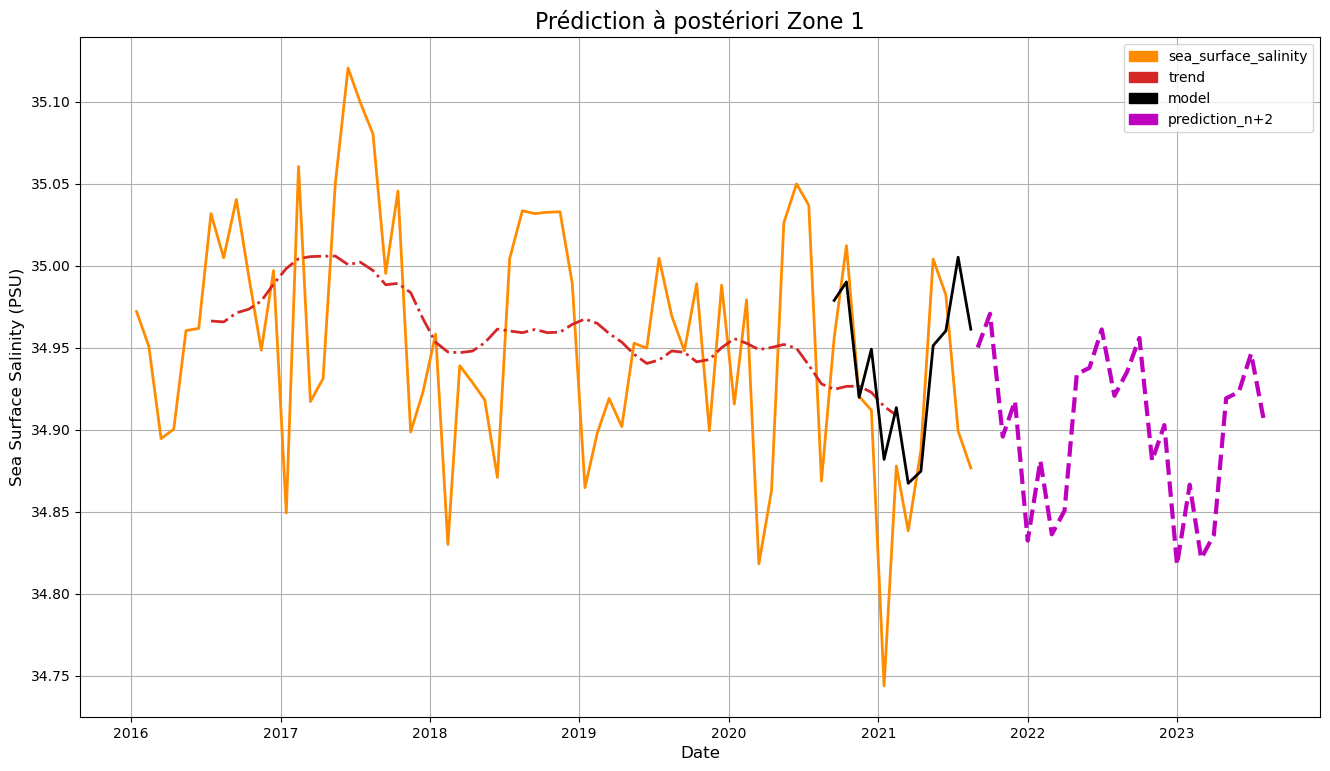

In [178]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_salinity'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 1",fontsize=16)
my_colors = {"sea_surface_salinity":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Salinity (PSU)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_005_pred_Z1_SAL.jpg',dpi=300)
plt.show()

### Metrics

In [179]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_salinity'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.6559
mae       0.0469
mape      0.0013
me       -0.0286
mpe      -0.0008
rmse      0.0615

### Analyse bruit & résidus

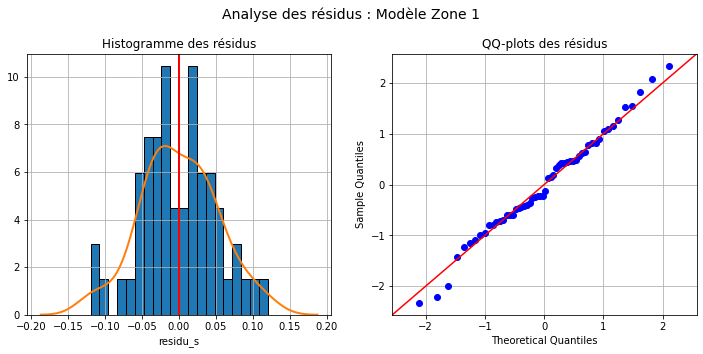

ShapiroResult(statistic=0.9881159067153931, pvalue=0.8546029329299927)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

   lb_stat  lb_pvalue
6  2.71984   0.843098
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [180]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 1", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_005_resid_Z1_SAL.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 2

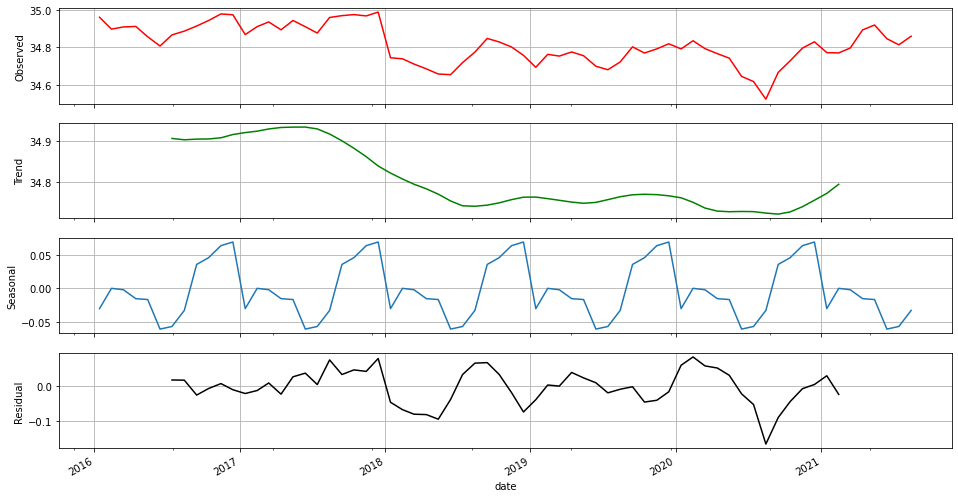

In [181]:
import statsmodels.api as sm

g = Z2.groupby(['date']).agg({'sea_surface_salinity':'mean'})
X = g['sea_surface_salinity']

model2_Sal = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model2_Sal.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model2_Sal.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model2_Sal.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model2_Sal.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_006_decomposition_Z2_SAL.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
#                             'sea_surface_temperature': g["sea_surface_temperature"].values,
                            'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': model2_Sal.trend.values,
                            'seasonal': model2_Sal.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model2_Sal.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

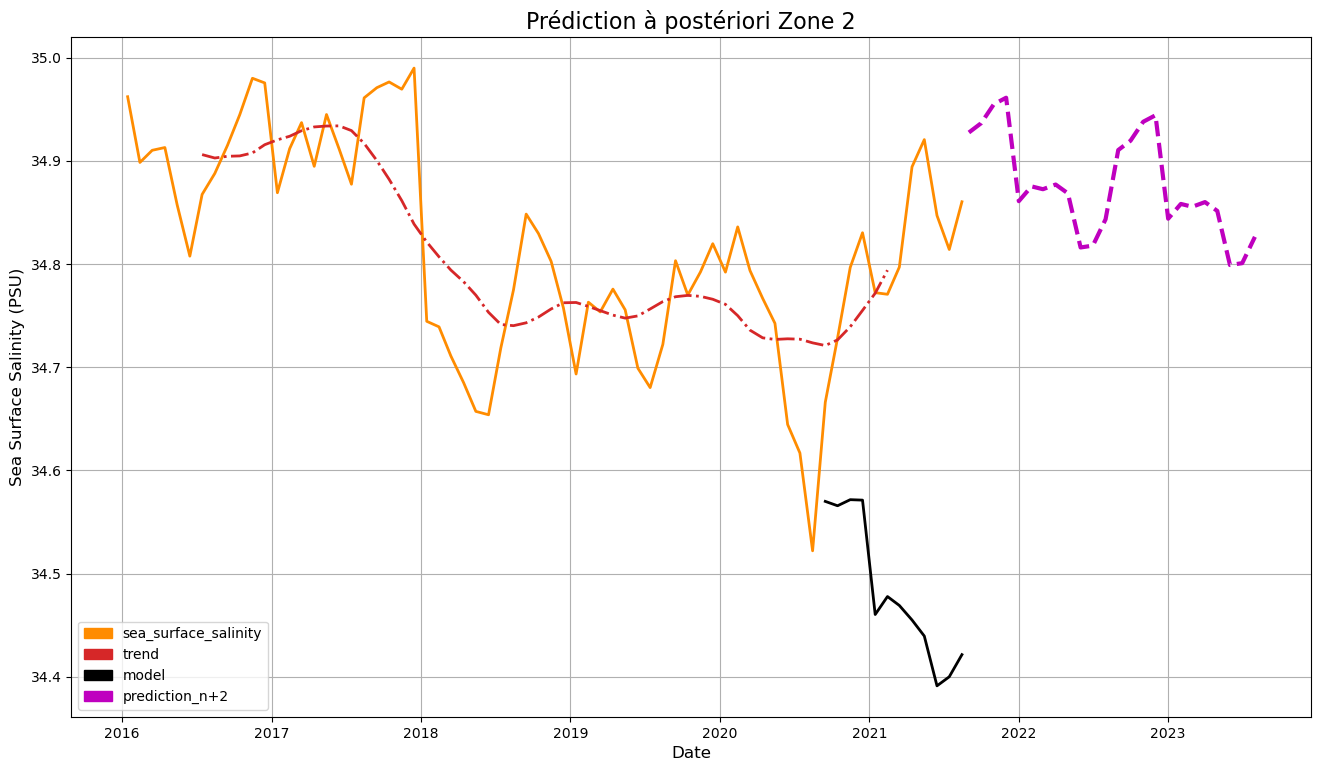

In [182]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_salinity'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 2",fontsize=16)
my_colors = {"sea_surface_salinity":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Salinity (PSU)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_006_pred_Z2_SAL.jpg',dpi=300)
plt.show()

### Metrics

In [183]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_salinity'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr     -0.5884
mae       0.3254
mape      0.0093
me        0.3254
mpe       0.0094
rmse      0.3465

### Analyse bruit & résidus

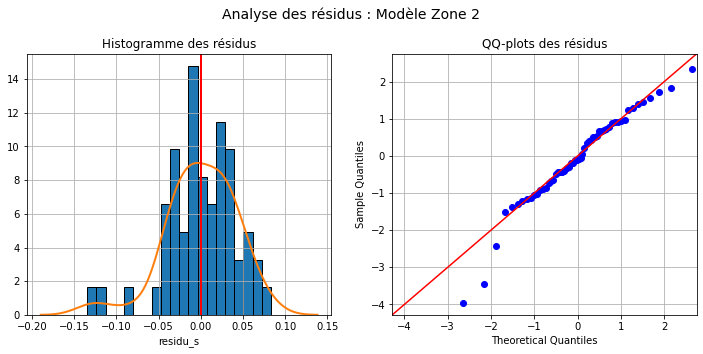

ShapiroResult(statistic=0.9555688500404358, pvalue=0.03796931356191635)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  5.546693   0.475831
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [184]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 2", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_006_resid_Z2_SAL.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 3

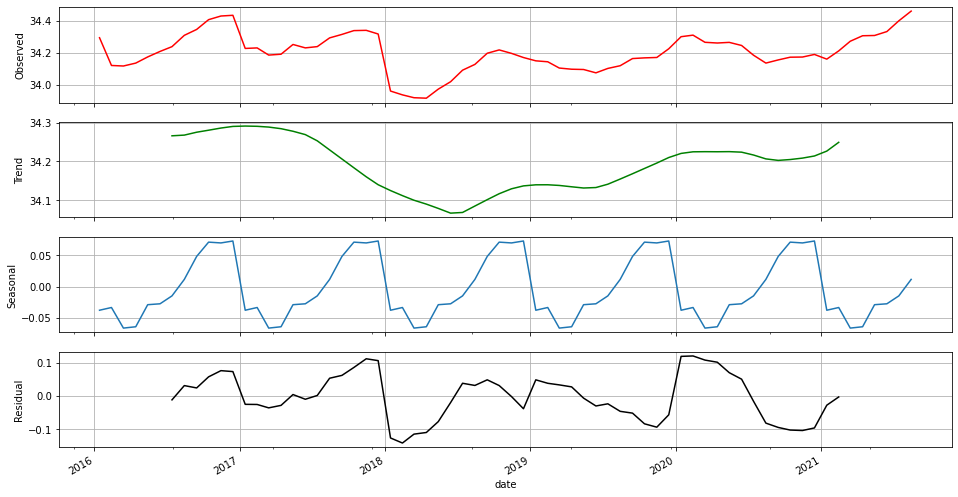

In [185]:
import statsmodels.api as sm

g = Z3.groupby(['date']).agg({'sea_surface_salinity':'mean'})
X = g['sea_surface_salinity']

model3_Sal = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model3_Sal.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model3_Sal.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model3_Sal.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model3_Sal.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_007_decomposition_Z3_SAL.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
#                             'sea_surface_temperature': g["sea_surface_temperature"].values,
                            'sea_surface_salinity': g["sea_surface_salinity"].values,
                            'trend': model3_Sal.trend.values,
                            'seasonal': model3_Sal.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model3_Sal.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

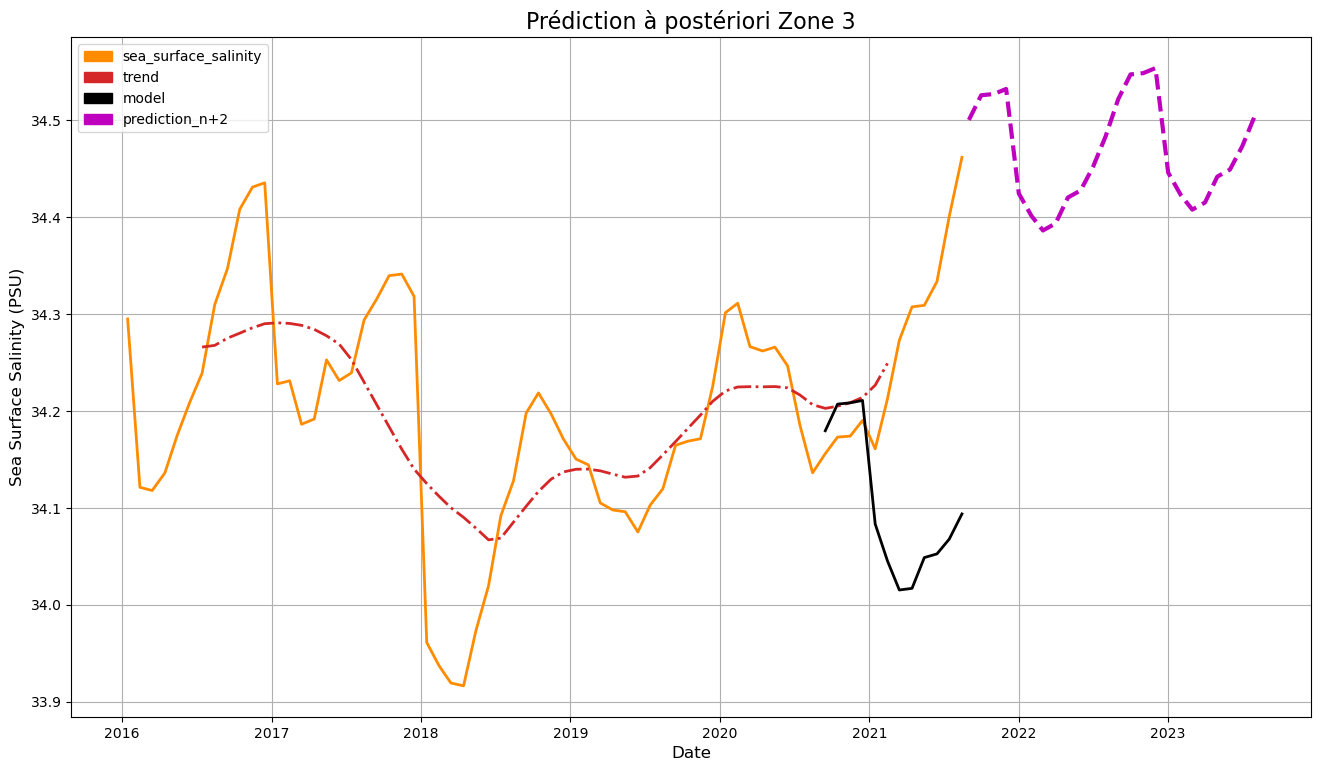

In [186]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['sea_surface_salinity'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['sea_surface_salinity'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 3",fontsize=16)
my_colors = {"sea_surface_salinity":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Sea Surface Salinity (PSU)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_007_pred_Z3_SAL.jpg',dpi=300)
plt.show()

### Metrics

In [187]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['sea_surface_salinity'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr     -0.5508
mae       0.1790
mape      0.0052
me        0.1602
mpe       0.0047
rmse      0.2201

### Analyse bruit & résidus

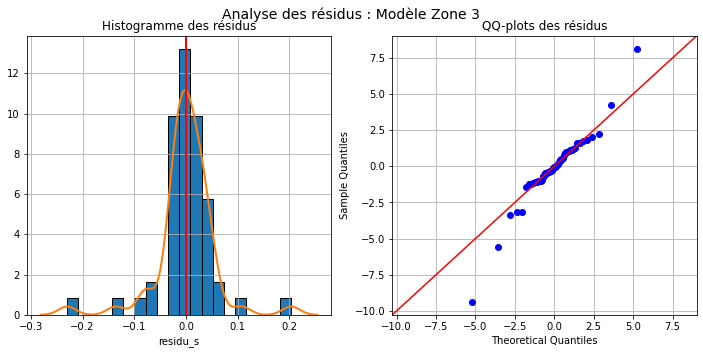

ShapiroResult(statistic=0.8336852788925171, pvalue=2.028261405939702e-06)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  5.510434   0.480197
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [188]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 3", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_007_resid_Z3_SAL.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition RESUME

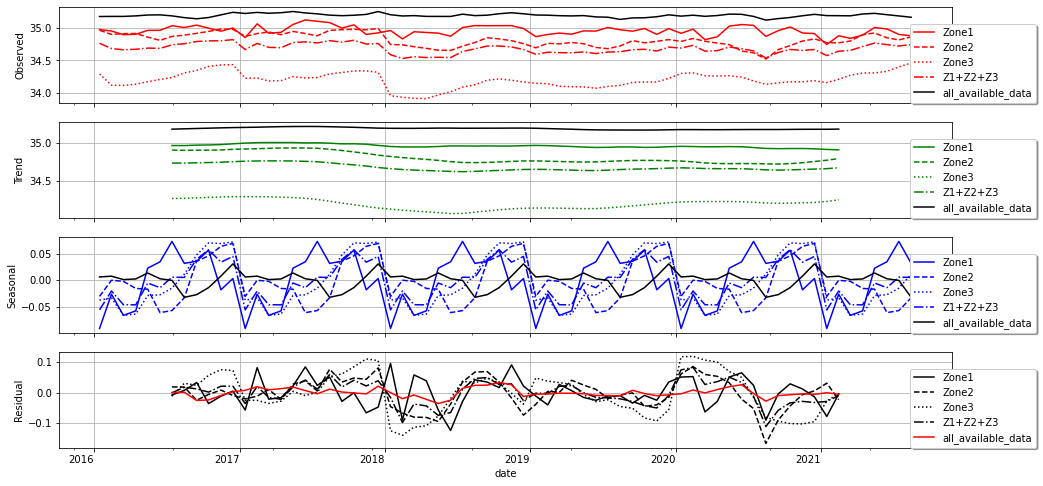

In [189]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

g = table_init.groupby(['date']).agg({'sea_surface_salinity':'mean'})
X = g['sea_surface_salinity']
model_all_Sal = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)

model1_Sal.observed.plot(ax=axes[0], legend=True, color='r', ls='-')
model2_Sal.observed.plot(ax=axes[0], legend=True, color='r', ls='--')
model3_Sal.observed.plot(ax=axes[0], legend=True, color='r', ls=':')
modelG_Sal.observed.plot(ax=axes[0], legend=True, color='r', ls='-.')
model_all_Sal.observed.plot(ax=axes[0], legend=True, color='k', ls='-')

axes[0].set_ylabel('Observed')
axes[0].grid()
import matplotlib.lines as mlines
colors = {'Zone1':'r','Zone2':'r','Zone3':'r','Z1+Z2+Z3':'r','all_available_data':'k'} 
style  = {'Zone1':'-','Zone2':'--','Zone3':':','Z1+Z2+Z3':'-.','all_available_data':'-'} 
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[0].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
# axes[0].set_ylim(5, 20)

model1_Sal.trend.plot(ax=axes[1], legend=True, color='g', ls='-')
model2_Sal.trend.plot(ax=axes[1], legend=True, color='g', ls='--')
model3_Sal.trend.plot(ax=axes[1], legend=True, color='g', ls=':')
modelG_Sal.trend.plot(ax=axes[1], legend=True, color='g', ls='-.')
model_all_Sal.trend.plot(ax=axes[1], legend=True, color='k', ls='-')

axes[1].set_ylabel('Trend')
axes[1].grid()
colors = {'Zone1':'g','Zone2':'g','Zone3':'g','Z1+Z2+Z3':'g','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[1].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
# axes[1].set_ylim(10, 14)

model1_Sal.seasonal.plot(ax=axes[2], legend=True, color='b',ls='-')
model2_Sal.seasonal.plot(ax=axes[2], legend=True, color='b',ls='--')
model3_Sal.seasonal.plot(ax=axes[2], legend=True, color='b',ls=':')
modelG_Sal.seasonal.plot(ax=axes[2], legend=True, color='b', ls='-.')
model_all_Sal.seasonal.plot(ax=axes[2], legend=True, color='k', ls='-')

axes[2].set_ylabel('Seasonal')
axes[2].grid()
colors = {'Zone1':'b','Zone2':'b','Zone3':'b','Z1+Z2+Z3':'b','all_available_data':'k'}  
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[2].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))

model1_Sal.resid.plot(ax=axes[3], legend=True, color='k',ls='-')
model2_Sal.resid.plot(ax=axes[3], legend=True, color='k',ls='--')
model3_Sal.resid.plot(ax=axes[3], legend=True, color='k',ls=':')
modelG_Sal.resid.plot(ax=axes[3], legend=True, color='k',ls='-.')
model_all_Sal.resid.plot(ax=axes[3], legend=True, color='r', ls='-')

axes[3].set_ylabel('Residual')
axes[3].grid()
# axes[3].set_ylim(-4.5, 4.5)

colors = {'Zone1':'k','Zone2':'k','Zone3':'k','Z1+Z2+Z3':'k','all_available_data':'r'}  
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[3].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
plt.xticks(rotation = 0)
plt.savefig('OUTPUTS_FORMATION/P8_007_decompo_RESUME_SAL.jpg',dpi=300)
plt.show()

## Prédictions MLD par Holt-Winters

### Decomposition Statsmodels

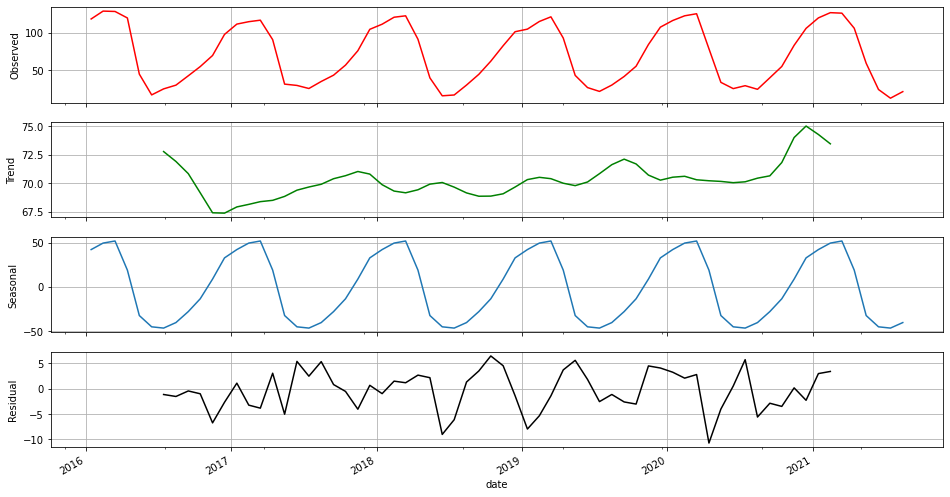

In [190]:
import statsmodels.api as sm

g = ZG.groupby(['date']).agg({'mixed_layer_depth':'mean'})
X = g['mixed_layer_depth']

modelG_MLD = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
modelG_MLD.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
modelG_MLD.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
modelG_MLD.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
modelG_MLD.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_004_decomposition_ZG_MLD.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'mixed_layer_depth': g["mixed_layer_depth"].values,
                            'trend': modelG_MLD.trend.values,
                            'seasonal': modelG_MLD.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': modelG_MLD.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage expnonentiel

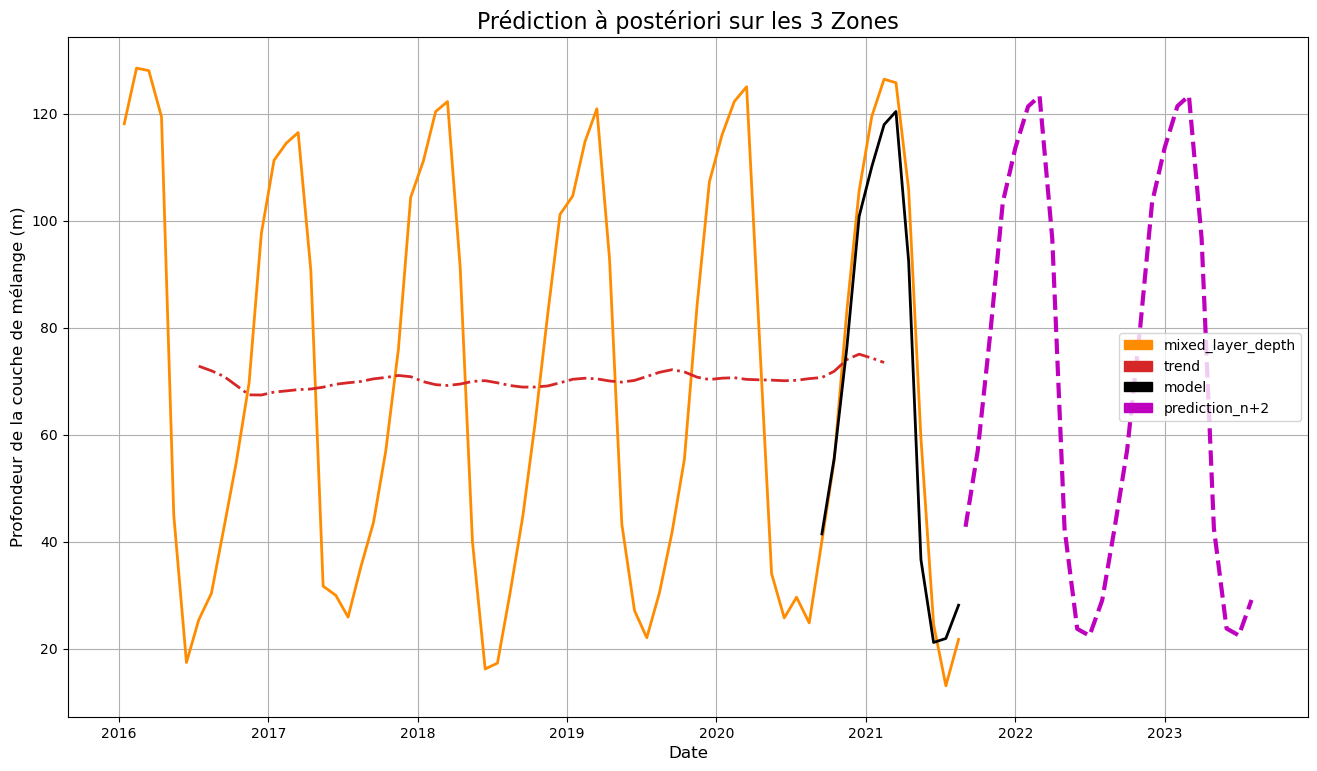

In [191]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['mixed_layer_depth'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori sur les 3 Zones",fontsize=16)
my_colors = {"mixed_layer_depth":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Profondeur de la couche de mélange (m)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_004_pred_ZG_MLD.jpg',dpi=300)
plt.show()

### Metrics

In [192]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['mixed_layer_depth'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9828
mae       7.6226
mape      0.1648
me        4.7840
mpe       0.0494
rmse      9.5235

### Analyse bruit & résidus

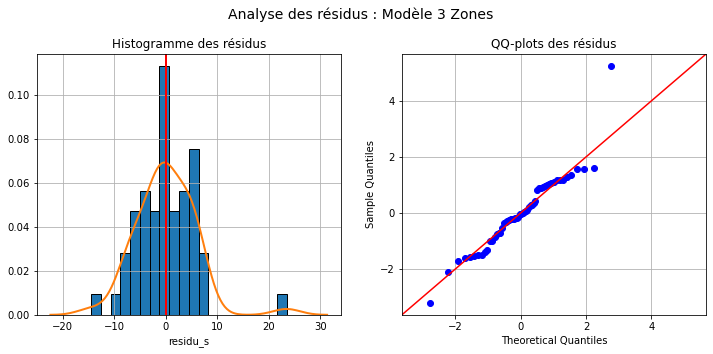

ShapiroResult(statistic=0.9250268340110779, pvalue=0.0018779841484501958)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

      lb_stat  lb_pvalue
12  19.127134   0.085506
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [193]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle 3 Zones", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_004_resid_ZG_MLD.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[12], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 1

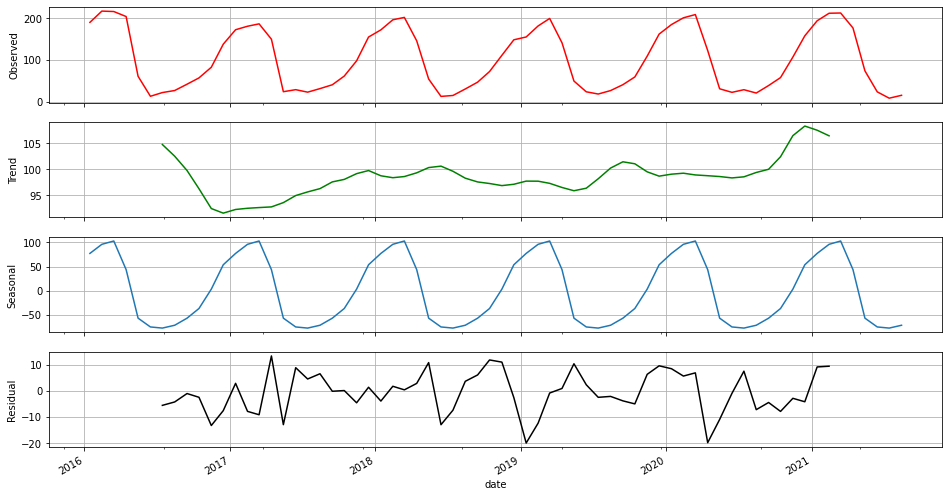

In [194]:
import statsmodels.api as sm

g = Z1.groupby(['date']).agg({'mixed_layer_depth':'mean'})
X = g['mixed_layer_depth']

model1_MLD = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model1_MLD.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model1_MLD.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model1_MLD.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model1_MLD.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_005_decomposition_Z1_MLD.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'mixed_layer_depth': g["mixed_layer_depth"].values,
                            'trend': model1_MLD.trend.values,
                            'seasonal': model1_MLD.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model1_MLD.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

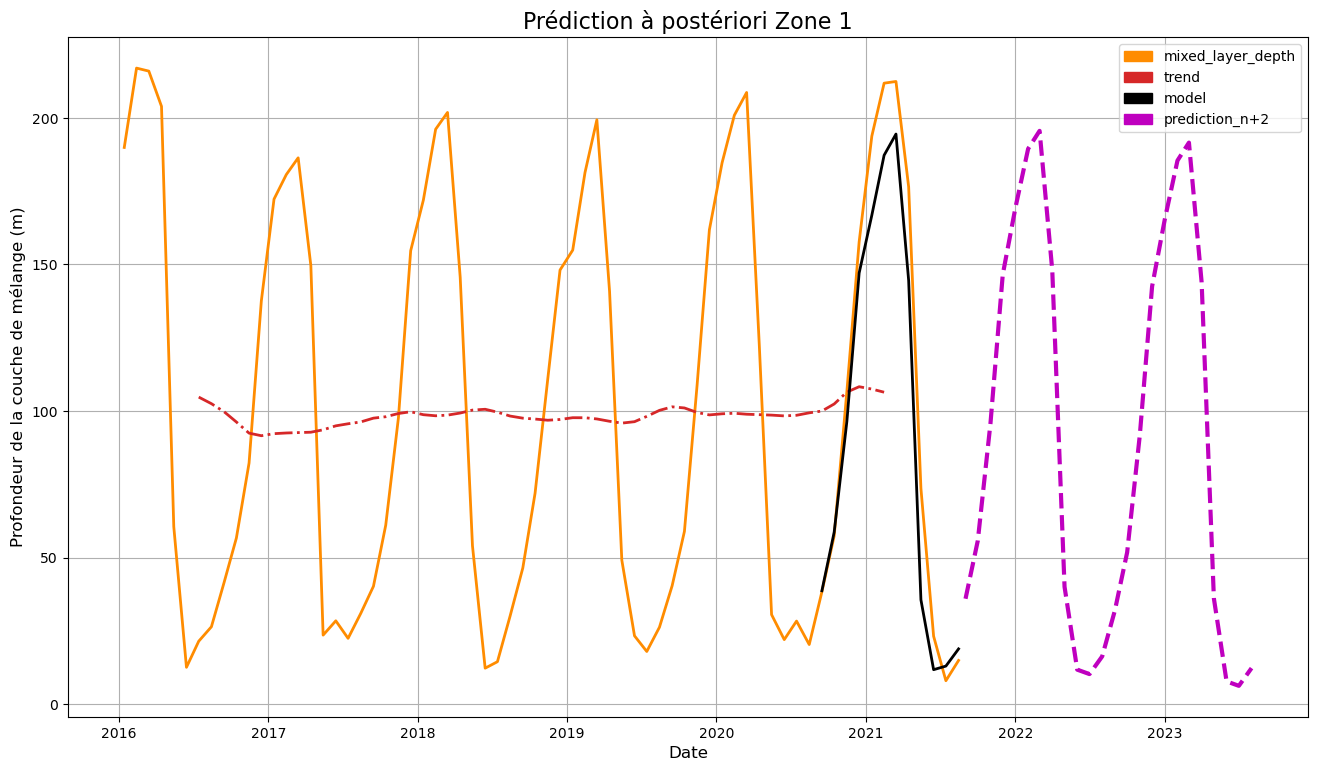

In [195]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['mixed_layer_depth'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 1",fontsize=16)
my_colors = {"mixed_layer_depth":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Profondeur de la couche de mélange (m)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_005_pred_Z1_MLD.jpg',dpi=300)
plt.show()

### Metrics

In [196]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['mixed_layer_depth'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9880
mae      15.1889
mape      0.2180
me       13.4305
mpe       0.1833
rmse     19.3862

### Analyse bruit & résidus

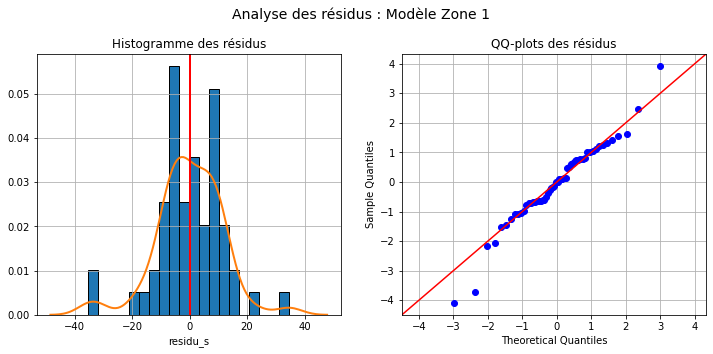

ShapiroResult(statistic=0.9549421072006226, pvalue=0.03555099293589592)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  3.269502    0.77434
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [197]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 1", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_005_resid_Z1_MLD.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 2

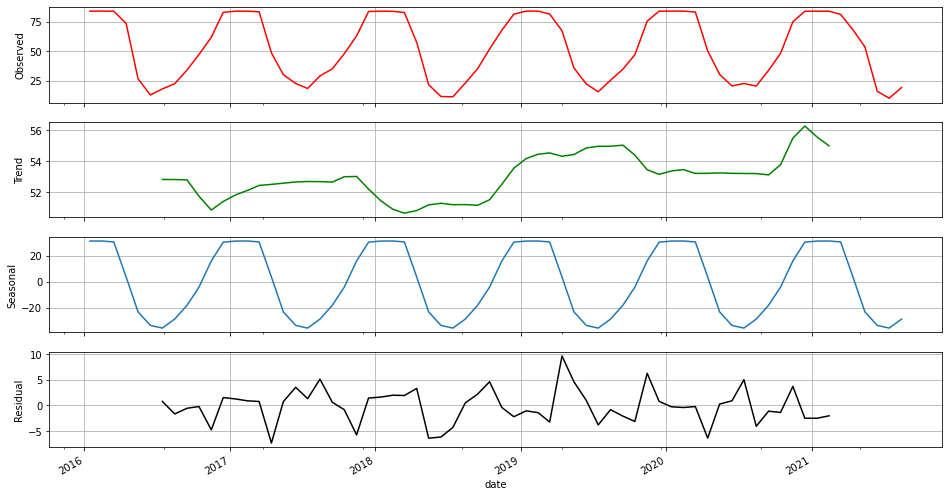

In [198]:
import statsmodels.api as sm

g = Z2.groupby(['date']).agg({'mixed_layer_depth':'mean'})
X = g['mixed_layer_depth']

model2_MLD = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model2_MLD.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model2_MLD.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model2_MLD.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model2_MLD.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_006_decomposition_Z2_MLD.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'mixed_layer_depth': g["mixed_layer_depth"].values,
                            'trend': model2_MLD.trend.values,
                            'seasonal': model2_MLD.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model2_MLD.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

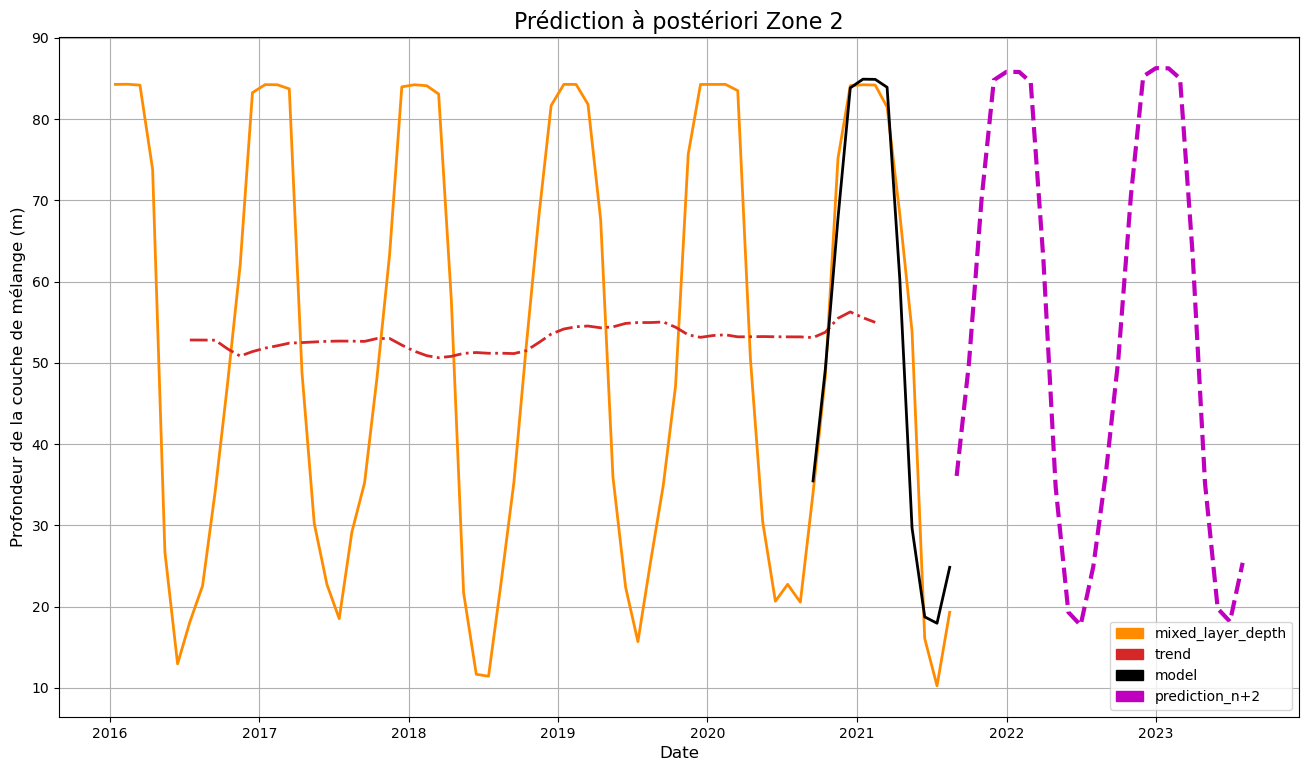

In [199]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['mixed_layer_depth'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 2",fontsize=16)
my_colors = {"mixed_layer_depth":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Profondeur de la couche de mélange (m)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_006_pred_Z2_MLD.jpg',dpi=300)
plt.show()

### Metrics

In [200]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['mixed_layer_depth'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9561
mae       5.1618
mape      0.1651
me        1.4712
mpe       0.0132
rmse      8.2162

### Analyse bruit & résidus

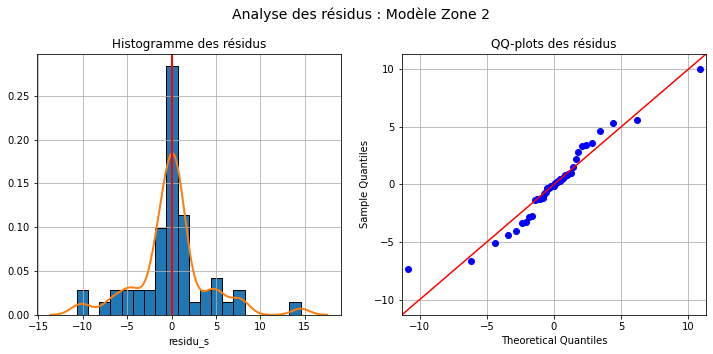

ShapiroResult(statistic=0.9198657870292664, pvalue=0.0011794290039688349)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  3.665058   0.721896
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [201]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 2", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_006_resid_Z2_MLD.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition Statsmodels Zone 3

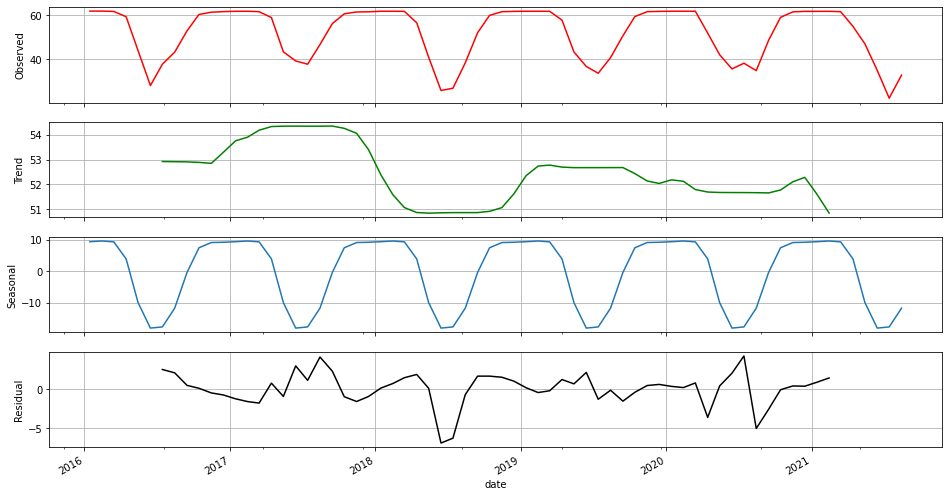

In [202]:
import statsmodels.api as sm

g = Z3.groupby(['date']).agg({'mixed_layer_depth':'mean'})
X = g['mixed_layer_depth']

model3_MLD = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
# resplot = model.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)
# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model3_MLD.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
axes[0].grid()
# axes[0].set_ylim(7, 19)
model3_MLD.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
# axes[1].set_ylim(7, 19)
axes[1].grid()
model3_MLD.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
# axes[2].axhline(5, c='m',ls='--')
# axes[2].axhline(-3, c='m',ls='--')
axes[2].grid()
model3_MLD.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
axes[3].grid()
plt.savefig('OUTPUTS_FORMATION/P8_007_decomposition_Z3_MLD.jpg',dpi=300)
plt.show()

# création d'un df regroupant les infos importantes de la décomposition
decompose_T = pd.DataFrame({
                            'mixed_layer_depth': g["mixed_layer_depth"].values,
                            'trend': model3_MLD.trend.values,
                            'seasonal': model3_MLD.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model3_MLD.resid.values,
                        })

indexes = decompose_T.set_index(pd.to_datetime(g.index))

### Approximation et prédiction par lissage exponentiel

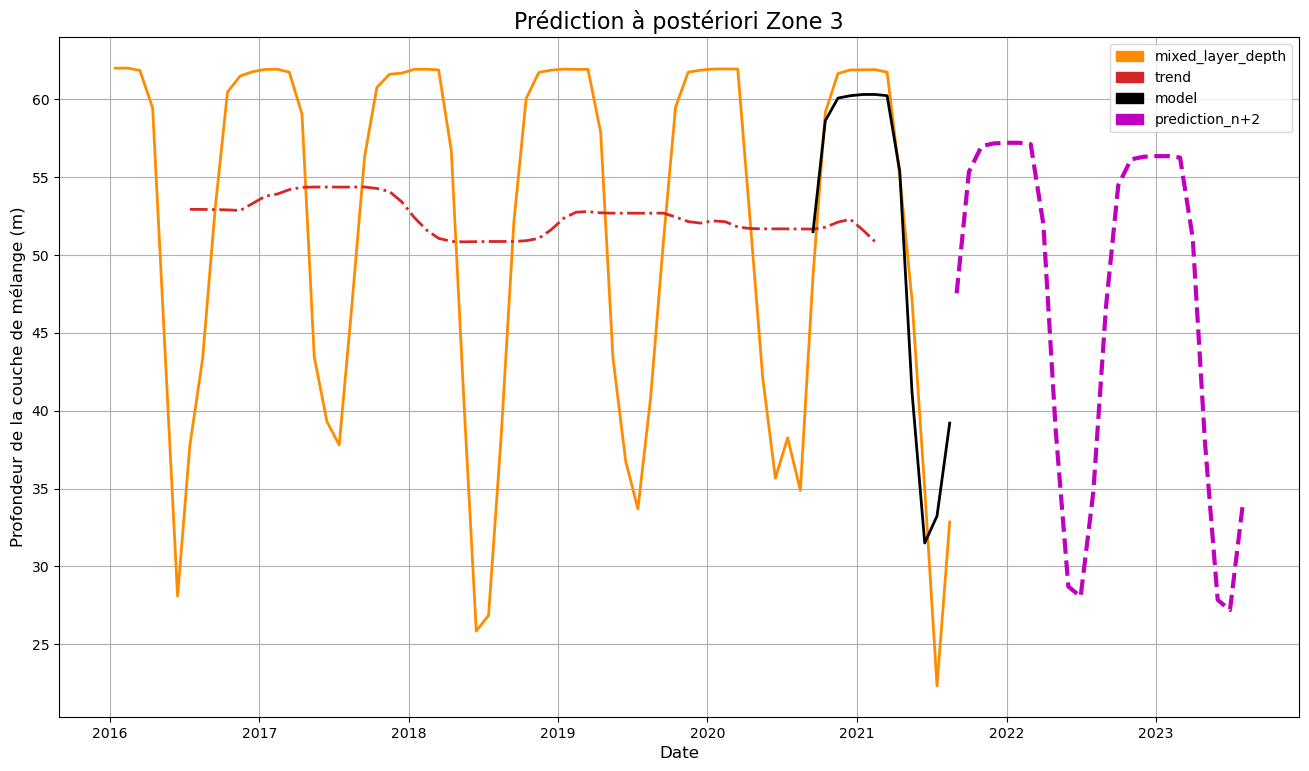

In [203]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# on retire les données des 12 mois
train = g[:len(g)-12] 
test  = g[len(g)-12:len(g)]
model_triple_pred_1 = ExponentialSmoothing(train['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test))

y=('2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01', 
   '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01','2022-07-01', '2022-08-01', 
   '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01','2023-01-01', '2023-02-01', 
   '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01','2023-07-01', '2023-08-01', 
#    '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01','2024-01-01', '2024-02-01',
#    '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01','2024-07-01', '2024-08-01', 
#    '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01','2025-01-01', '2025-02-01', 
#    '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)
model_triple_pred_post = ExponentialSmoothing(decompose_T['mixed_layer_depth'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_triple_pred_post.forecast(len(y))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
ax.plot(indexes.index, g['mixed_layer_depth'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose_T["trend"]        ,lw=2, c='tab:red',ls='-.')
ax.plot(indexes.index[len(g)-12:len(g)], prediction_1,lw=2, c='k',ls='-')
ax.plot(ind_2022, pred_np1_HW,                        lw=3, c='m',ls='--')
ax.set_title("Prédiction à postériori Zone 3",fontsize=16)
my_colors = {"mixed_layer_depth":'darkorange',"trend":'tab:red', "model":'k' , "prediction_n+2":'m'} 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=False, loc='best',fontsize=10)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Profondeur de la couche de mélange (m)",fontsize=12)
# ax.set_ylim(6,18)
ax.grid()
plt.savefig('OUTPUTS_FORMATION/P8_007_pred_Z3_MLD.jpg',dpi=300)
plt.show()

### Metrics

In [204]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test['mixed_layer_depth'].values,prediction_1.values)
df_metrics = pd.DataFrame({'prediction': d1}).round(4)
df_metrics

prediction
corr      0.9527
mae       3.1869
mape      0.0923
me       -0.2152
mpe      -0.0131
rmse      4.3510

### Analyse bruit & résidus

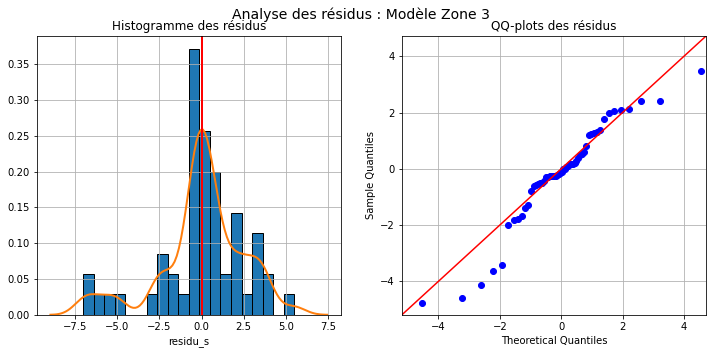

ShapiroResult(statistic=0.9302101731300354, pvalue=0.0030333339236676693)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 

    lb_stat  lb_pvalue
6  3.007237   0.807938
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


In [205]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle Zone 3", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
train['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P8_007_resid_Z3_MLD.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')
print('')
print(sm.stats.acorr_ljungbox(model_triple_pred_1.resid, lags=[6], return_df=True))
print('\x1b[6;32;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

### Decomposition RESUME

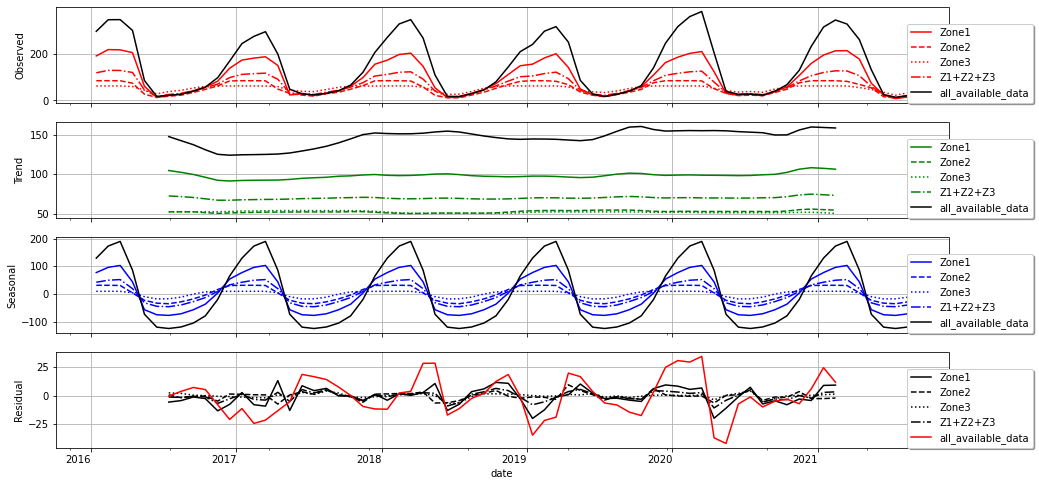

In [206]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

g = table_init.groupby(['date']).agg({'mixed_layer_depth':'mean'})
X = g['mixed_layer_depth']
model_all_MLD = sm.tsa.seasonal_decompose(X, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)

model1_MLD.observed.plot(ax=axes[0], legend=True, color='r', ls='-')
model2_MLD.observed.plot(ax=axes[0], legend=True, color='r', ls='--')
model3_MLD.observed.plot(ax=axes[0], legend=True, color='r', ls=':')
modelG_MLD.observed.plot(ax=axes[0], legend=True, color='r', ls='-.')
model_all_MLD.observed.plot(ax=axes[0], legend=True, color='k', ls='-')

axes[0].set_ylabel('Observed')
axes[0].grid()
import matplotlib.lines as mlines
colors = {'Zone1':'r','Zone2':'r','Zone3':'r','Z1+Z2+Z3':'r','all_available_data':'k'} 
style  = {'Zone1':'-','Zone2':'--','Zone3':':','Z1+Z2+Z3':'-.','all_available_data':'-'} 
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[0].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
# axes[0].set_ylim(5, 20)

model1_MLD.trend.plot(ax=axes[1], legend=True, color='g', ls='-')
model2_MLD.trend.plot(ax=axes[1], legend=True, color='g', ls='--')
model3_MLD.trend.plot(ax=axes[1], legend=True, color='g', ls=':')
modelG_MLD.trend.plot(ax=axes[1], legend=True, color='g', ls='-.')
model_all_MLD.trend.plot(ax=axes[1], legend=True, color='k', ls='-')

axes[1].set_ylabel('Trend')
axes[1].grid()
colors = {'Zone1':'g','Zone2':'g','Zone3':'g','Z1+Z2+Z3':'g','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[1].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
# axes[1].set_ylim(10, 14)

model1_MLD.seasonal.plot(ax=axes[2], legend=True, color='b',ls='-')
model2_MLD.seasonal.plot(ax=axes[2], legend=True, color='b',ls='--')
model3_MLD.seasonal.plot(ax=axes[2], legend=True, color='b',ls=':')
modelG_MLD.seasonal.plot(ax=axes[2], legend=True, color='b', ls='-.')
model_all_MLD.seasonal.plot(ax=axes[2], legend=True, color='k', ls='-')

axes[2].set_ylabel('Seasonal')
axes[2].grid()
colors = {'Zone1':'b','Zone2':'b','Zone3':'b','Z1+Z2+Z3':'b','all_available_data':'k'}  
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[2].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))

model1_MLD.resid.plot(ax=axes[3], legend=True, color='k',ls='-')
model2_MLD.resid.plot(ax=axes[3], legend=True, color='k',ls='--')
model3_MLD.resid.plot(ax=axes[3], legend=True, color='k',ls=':')
modelG_MLD.resid.plot(ax=axes[3], legend=True, color='k',ls='-.')
model_all_MLD.resid.plot(ax=axes[3], legend=True, color='r', ls='-')

axes[3].set_ylabel('Residual')
axes[3].grid()
# axes[3].set_ylim(-4.5, 4.5)

colors = {'Zone1':'k','Zone2':'k','Zone3':'k','Z1+Z2+Z3':'k','all_available_data':'r'}  
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
axes[3].legend(handles, labels, ncol=1, shadow=True, loc='lower right',fontsize=10, bbox_to_anchor=(1.1, -0.05))
plt.xticks(rotation = 0)
plt.savefig('OUTPUTS_FORMATION/P8_007_decompo_RESUME_MLD.jpg',dpi=300)
plt.show()

## ALL Trends

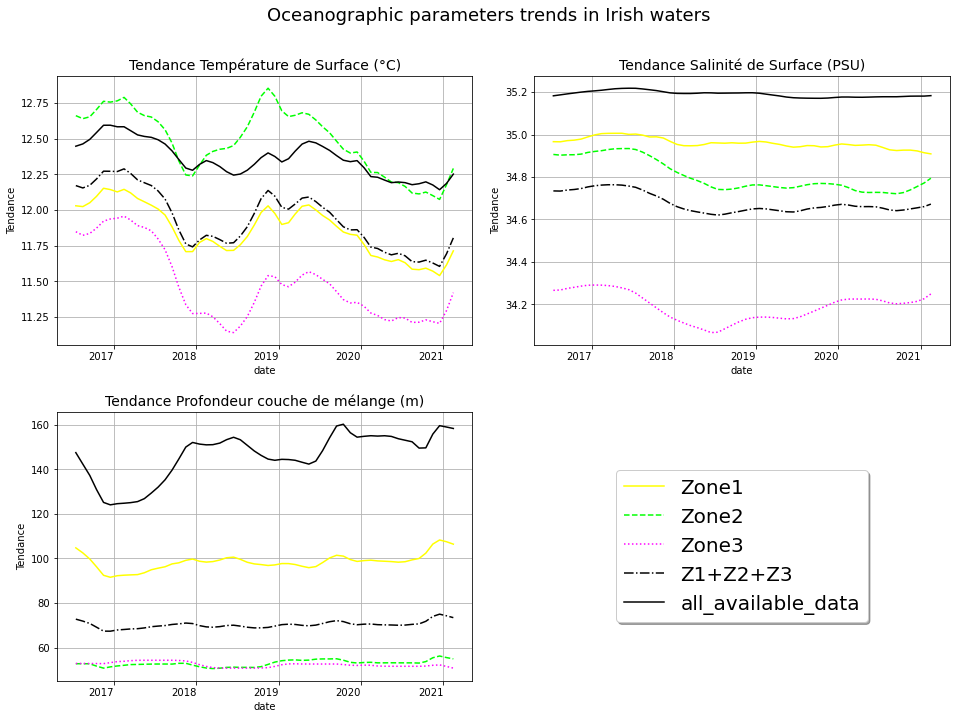

In [256]:
plt.subplots(figsize=(16, 12))
plt.suptitle("Oceanographic parameters trends in Irish waters" , fontsize=18)
# plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=.25, wspace=.15)

# -----------------------------------------------------------------------------------
plt.subplot(2, 2, 1)
model1_Tsurf.trend.plot(legend=False, color='yellow', ls='-')
model2_Tsurf.trend.plot(legend=False, color='lime', ls='--')
model3_Tsurf.trend.plot(legend=False, color='magenta', ls=':')
modelG_Tsurf.trend.plot(legend=False, color='k', ls='-.')
model_all_Tsurf.trend.plot(legend=False, color='k', ls='-')
plt.ylabel('Tendance')
plt.grid()
colors = {'Zone1':'y','Zone2':'lime','Zone3':'m','Z1+Z2+Z3':'k','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
# plt.legend(handles, labels, ncol=1, shadow=True, loc='best',fontsize=10)#, bbox_to_anchor=(1.4, 0.25)
plt.title("Tendance Température de Surface (°C)", fontsize=14)
plt.xticks(rotation=0)

# -----------------------------------------------------------------------------------
plt.subplot(2, 2, 2)
model1_Sal.trend.plot(legend=False, color='yellow', ls='-')
model2_Sal.trend.plot(legend=False, color='lime', ls='--')
model3_Sal.trend.plot(legend=False, color='magenta', ls=':')
modelG_Sal.trend.plot(legend=False, color='k', ls='-.')
model_all_Sal.trend.plot(legend=False, color='k', ls='-')
plt.ylabel('Tendance')
plt.grid()
colors = {'Zone1':'y','Zone2':'lime','Zone3':'m','Z1+Z2+Z3':'k','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
# plt.legend(handles, labels, ncol=1, shadow=True, loc='best',fontsize=10)#, bbox_to_anchor=(1.4, 0.25)
plt.title("Tendance Salinité de Surface (PSU)", fontsize=14)
plt.xticks(rotation=0)

# -----------------------------------------------------------------------------------
plt.subplot(2, 2, 3)
model1_MLD.trend.plot(legend=False, color='yellow', ls='-')
model2_MLD.trend.plot(legend=False, color='lime', ls='--')
model3_MLD.trend.plot(legend=False, color='magenta', ls=':')
modelG_MLD.trend.plot(legend=False, color='k', ls='-.')
model_all_MLD.trend.plot(legend=False, color='k', ls='-')
plt.ylabel('Tendance')
plt.grid()
colors = {'Zone1':'y','Zone2':'lime','Zone3':'m','Z1+Z2+Z3':'k','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
# plt.legend(handles, labels, ncol=1, shadow=True, loc='best',fontsize=10)#, bbox_to_anchor=(1.4, 0.25)
plt.title("Tendance Profondeur couche de mélange (m)", fontsize=14)
plt.xticks(rotation=0)

# -----------------------------------------------------------------------------------
plt.subplot(2, 2, 4)
colors = {'Zone1':'yellow','Zone2':'lime','Zone3':'magenta','Z1+Z2+Z3':'k','all_available_data':'k'} 
handles = [mlines.Line2D([], [], color=colors[label], linestyle=style[label]) for label in labels] 
plt.legend(handles, labels, ncol=1, shadow=True, loc='center',fontsize=20)#, bbox_to_anchor=(1.4, 0.25)
plt.tick_params(labelbottom=False, labelleft=False)
plt.xticks([]) 
plt.yticks([])
plt.axis('off')

plt.savefig('OUTPUTS_FORMATION/P8_007_decompo_RESUME_TRENDS.jpg')#,dpi=300
plt.show()

## Suivi dynamique

### Couche de mélange

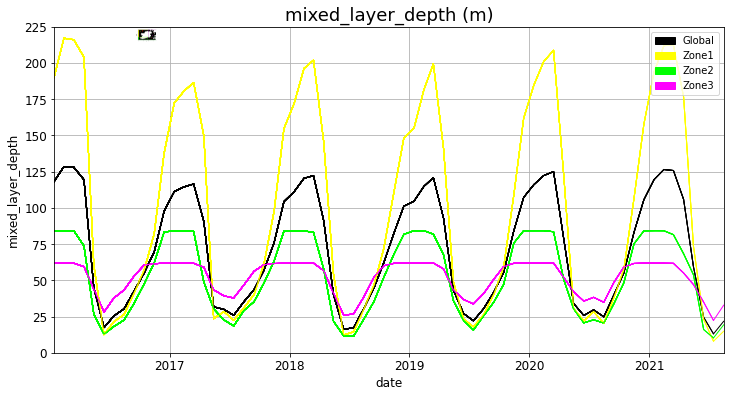

In [133]:
im = plt.imread('P8_Zonages_Z1_Z2_Z3.jpg')
import matplotlib.animation as animation
%matplotlib inline
title = 'mixed_layer_depth'
Mixed_avg= ZG.groupby(['date']).agg({title:'mean'})
Mixed_Z1 = Z1.groupby(['date']).agg({title:'mean'})
Mixed_Z2 = Z2.groupby(['date']).agg({title:'mean'})
Mixed_Z3 = Z3.groupby(['date']).agg({title:'mean'})
MLD = Mixed_avg.copy()
MLD.columns = {title}
## conda install -c conda-forge ffmpeg
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure(figsize=(12,6))
plt.xlim(np.min(MLD.index),np.max(MLD.index))
plt.ylim(0, 225)
plt.title(str(title) +' (m)',fontsize=18)
plt.grid()
my_colors = {'Global':'k','Zone1':'yellow','Zone2':'lime','Zone3':'magenta'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
def animate(i):
    data   = MLD.iloc[:int(i+1)] 
    dataZ1 = Mixed_Z1.iloc[:int(i+1)] 
    dataZ2 = Mixed_Z2.iloc[:int(i+1)] 
    dataZ3 = Mixed_Z3.iloc[:int(i+1)] 
    p = sns.lineplot(x=data.index    , y=data[title]  , data=data, color="k")
    pZ1 = sns.lineplot(x=dataZ1.index, y=dataZ1[title], data=dataZ1, color="yellow")
    pZ2 = sns.lineplot(x=dataZ2.index, y=dataZ2[title], data=dataZ2, color="lime")
    pZ3 = sns.lineplot(x=dataZ3.index, y=dataZ3[title], data=dataZ3, color="magenta")
    p.tick_params(labelsize=12)
    plt.setp(p.lines,linewidth=1)
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='upper right',fontsize=10)
plt.ylabel(title, fontsize=12)
plt.xlabel(data.index.names, fontsize=12)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=68, repeat=True)  
ani.save('OUTPUTS_FORMATION/P8_016_MLD_par_Zones.mp4', writer=writer)
newax = fig.add_axes([0.22, 0.70, 0.175, 0.175], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.savefig('OUTPUTS_FORMATION/P8_016_MLD_par_Zones.jpg',dpi=300)
plt.show()

### Salinité

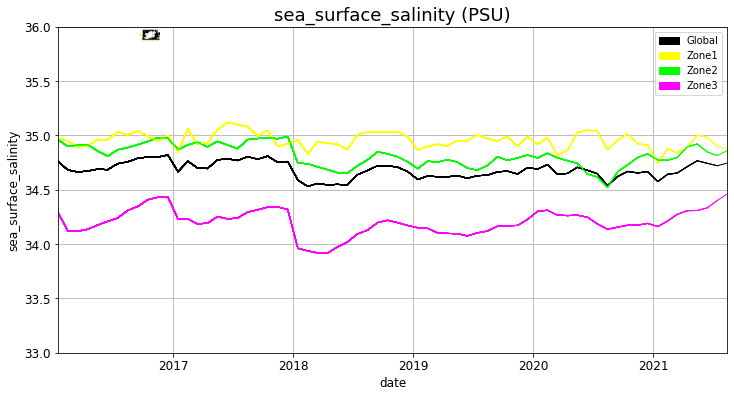

In [134]:
im = plt.imread('P8_Zonages_Z1_Z2_Z3.jpg')
import matplotlib.animation as animation
%matplotlib inline
title = 'sea_surface_salinity'
Mixed_avg= ZG.groupby(['date']).agg({title:'mean'})
Mixed_Z1 = Z1.groupby(['date']).agg({title:'mean'})
Mixed_Z2 = Z2.groupby(['date']).agg({title:'mean'})
Mixed_Z3 = Z3.groupby(['date']).agg({title:'mean'})
MLD = Mixed_avg.copy()
MLD.columns = {title}
## conda install -c conda-forge ffmpeg
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure(figsize=(12,6))
plt.xlim(np.min(MLD.index),np.max(MLD.index))
plt.ylim(33, 36)
plt.title(str(title) +' (PSU)',fontsize=18)
plt.grid()
my_colors = {'Global':'k','Zone1':'yellow','Zone2':'lime','Zone3':'magenta'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
def animate(i):
    data   = MLD.iloc[:int(i+1)] 
    dataZ1 = Mixed_Z1.iloc[:int(i+1)] 
    dataZ2 = Mixed_Z2.iloc[:int(i+1)] 
    dataZ3 = Mixed_Z3.iloc[:int(i+1)] 
    p = sns.lineplot(x=data.index    , y=data[title]  , data=data, color="k")
    pZ1 = sns.lineplot(x=dataZ1.index, y=dataZ1[title], data=dataZ1, color="yellow")
    pZ2 = sns.lineplot(x=dataZ2.index, y=dataZ2[title], data=dataZ2, color="lime")
    pZ3 = sns.lineplot(x=dataZ3.index, y=dataZ3[title], data=dataZ3, color="magenta")
    p.tick_params(labelsize=12)
    plt.setp(p.lines,linewidth=1)
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='upper right',fontsize=10)
plt.ylabel(title, fontsize=12)
plt.xlabel(data.index.names, fontsize=12)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=68, repeat=True)  
ani.save('OUTPUTS_FORMATION/P8_017_Salin_par_Zones.mp4', writer=writer)
newax = fig.add_axes([0.22, 0.70, 0.175, 0.175], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.savefig('OUTPUTS_FORMATION/P8_017_Salin_par_Zones.jpg',dpi=300)
plt.show()

### Température de Surface

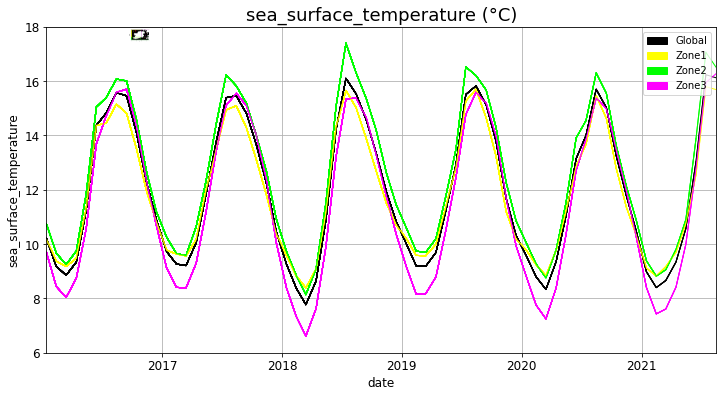

In [135]:
im = plt.imread('P8_Zonages_Z1_Z2_Z3.jpg')
import matplotlib.animation as animation
%matplotlib inline
title = 'sea_surface_temperature'
Mixed_avg= ZG.groupby(['date']).agg({title:'mean'})
Mixed_Z1 = Z1.groupby(['date']).agg({title:'mean'})
Mixed_Z2 = Z2.groupby(['date']).agg({title:'mean'})
Mixed_Z3 = Z3.groupby(['date']).agg({title:'mean'})
MLD = Mixed_avg.copy()
MLD.columns = {title}
## conda install -c conda-forge ffmpeg
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure(figsize=(12,6))
plt.xlim(np.min(MLD.index),np.max(MLD.index))
plt.ylim(6, 18)
plt.title(str(title) +' (°C)',fontsize=18)
plt.grid()
my_colors = {'Global':'k','Zone1':'yellow','Zone2':'lime','Zone3':'magenta'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
def animate(i):
    data   = MLD.iloc[:int(i+1)] 
    dataZ1 = Mixed_Z1.iloc[:int(i+1)] 
    dataZ2 = Mixed_Z2.iloc[:int(i+1)] 
    dataZ3 = Mixed_Z3.iloc[:int(i+1)] 
    p = sns.lineplot(x=data.index    , y=data[title]  , data=data, color="k")
    pZ1 = sns.lineplot(x=dataZ1.index, y=dataZ1[title], data=dataZ1, color="yellow")
    pZ2 = sns.lineplot(x=dataZ2.index, y=dataZ2[title], data=dataZ2, color="lime")
    pZ3 = sns.lineplot(x=dataZ3.index, y=dataZ3[title], data=dataZ3, color="magenta")
    p.tick_params(labelsize=12)
    plt.setp(p.lines,linewidth=1)
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='upper right',fontsize=10)
plt.ylabel(title, fontsize=12)
plt.xlabel(data.index.names, fontsize=12)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=68, repeat=True)  
ani.save('OUTPUTS_FORMATION/P8_018_Tsurf_par_Zones.mp4', writer=writer)
newax = fig.add_axes([0.22, 0.70, 0.175, 0.175], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.savefig('OUTPUTS_FORMATION/P8_018_Tsurf_par_Zones.jpg',dpi=300)
plt.show()

### Température de Fond

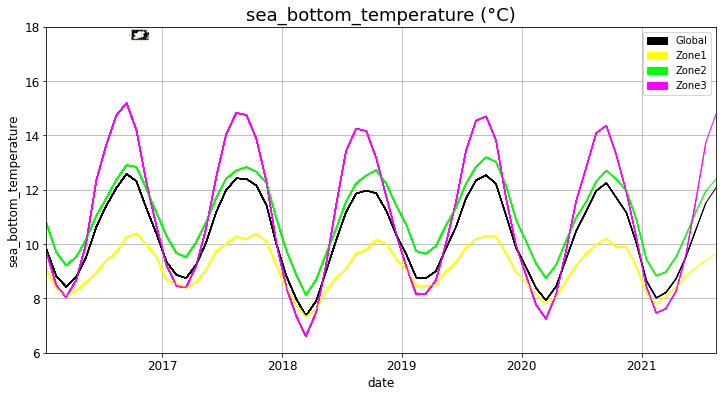

In [136]:
im = plt.imread('P8_Zonages_Z1_Z2_Z3.jpg')
import matplotlib.animation as animation
%matplotlib inline
title = 'sea_bottom_temperature'
Mixed_avg= ZG.groupby(['date']).agg({title:'mean'})
Mixed_Z1 = Z1.groupby(['date']).agg({title:'mean'})
Mixed_Z2 = Z2.groupby(['date']).agg({title:'mean'})
Mixed_Z3 = Z3.groupby(['date']).agg({title:'mean'})
MLD = Mixed_avg.copy()
MLD.columns = {title}
## conda install -c conda-forge ffmpeg
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure(figsize=(12,6))
plt.xlim(np.min(MLD.index),np.max(MLD.index))
plt.ylim(6, 18)
plt.title(str(title) +' (°C)',fontsize=18)
plt.grid()
my_colors = {'Global':'k','Zone1':'yellow','Zone2':'lime','Zone3':'magenta'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]  
def animate(i):
    data   = MLD.iloc[:int(i+1)] 
    dataZ1 = Mixed_Z1.iloc[:int(i+1)] 
    dataZ2 = Mixed_Z2.iloc[:int(i+1)] 
    dataZ3 = Mixed_Z3.iloc[:int(i+1)] 
    p = sns.lineplot(x=data.index    , y=data[title]  , data=data, color="k")
    pZ1 = sns.lineplot(x=dataZ1.index, y=dataZ1[title], data=dataZ1, color="yellow")
    pZ2 = sns.lineplot(x=dataZ2.index, y=dataZ2[title], data=dataZ2, color="lime")
    pZ3 = sns.lineplot(x=dataZ3.index, y=dataZ3[title], data=dataZ3, color="magenta")
    p.tick_params(labelsize=12)
    plt.setp(p.lines,linewidth=1)
plt.legend(handles, lab_col, ncol=1, shadow=False, loc='upper right',fontsize=10)
plt.ylabel(title, fontsize=12)
plt.xlabel(data.index.names, fontsize=12)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=68, repeat=True)  
ani.save('OUTPUTS_FORMATION/P8_019_Tbottom_par_Zones.mp4', writer=writer)
newax = fig.add_axes([0.22, 0.70, 0.175, 0.175], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.savefig('OUTPUTS_FORMATION/P8_019_Tbottom_par_Zones.jpg',dpi=300)
plt.show()